## Import packages

In [2]:
import sys
print(sys.version)

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from datetime import datetime
import os
import pandas as pd
import rasterio

3.12.5 | packaged by Anaconda, Inc. | (main, Sep 12 2024, 18:18:29) [MSC v.1929 64 bit (AMD64)]


In [3]:
# If using Google Colab, uncomment the following lines
# from google.colab import drive
# drive.mount('/content/drive')

## Create distance and bearing layers

In [4]:
# image_dim = 101
# pixel_size = 25
# center = image_dim // 2
# y, x = np.indices((image_dim, image_dim))

# distance_layer = np.sqrt((pixel_size*(x - center))**2 + (pixel_size*(y - center))**2)
# # change the centre cell to the average distance from the centre to the edge of the pixel
# distance_layer[center, center] = 0.56*pixel_size # average distance from the centre to the perimeter of the pixel (accounting for longer distances at the corners)
# bearing_layer = np.arctan2(center - y, x - center)

# # plot both of the layers
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(distance_layer)
# ax[0].set_title('Distance Layer')
# # add colour scale
# cbar = plt.colorbar(ax[0].imshow(distance_layer), ax=ax[0])
# ax[1].imshow(bearing_layer)
# ax[1].set_title('Bearing Layer')
# # add colour scale
# cbar = plt.colorbar(ax[1].imshow(bearing_layer), ax=ax[1])
# plt.show()


# Prepare data

## Set paths to data

In [5]:
# Get today's date
today_date = datetime.today().strftime('%Y-%m-%d')

# select the id to train the model on
buffalo_id = 2005
n_samples = 10297

# Specify the path to CSV file
csv_file_path = f'../buffalo_local_data_id/buffalo_{buffalo_id}_data_df_lag_1hr_n{n_samples}.csv'

# Path to your TIF file
ndvi_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_ndvi_cent101x101_lag_1hr_n{n_samples}.tif'
# Path to your TIF file
canopy_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_canopy_cent101x101_lag_1hr_n{n_samples}.tif'
# Path to your TIF file
herby_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_herby_cent101x101_lag_1hr_n{n_samples}.tif'
# Path to your TIF file
slope_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_slope_cent101x101_lag_1hr_n{n_samples}.tif'

# Path to your TIF file
pres_path = f'../buffalo_local_layers_id/buffalo_{buffalo_id}_pres_cent101x101_lag_1hr_n{n_samples}.tif'

## Read data

In [6]:
# Read the CSV file into a DataFrame
buffalo_df = pd.read_csv(csv_file_path)
print(buffalo_df.shape)

# Lag the values in column 'A' by one index
buffalo_df['bearing_tm1'] = buffalo_df['bearing'].shift(1)
# Pad the missing value with a specified value, e.g., 0
buffalo_df['bearing_tm1'] = buffalo_df['bearing_tm1'].fillna(0)

# Display the first few rows of the DataFrame
print(buffalo_df.head())

(10103, 35)
             x_            y_                    t_    id           x1_  \
0  41969.310875 -1.435671e+06  2018-07-25T01:04:23Z  2005  41969.310875   
1  41921.521939 -1.435654e+06  2018-07-25T02:04:39Z  2005  41921.521939   
2  41779.439594 -1.435601e+06  2018-07-25T03:04:17Z  2005  41779.439594   
3  41841.203272 -1.435635e+06  2018-07-25T04:04:39Z  2005  41841.203272   
4  41655.463332 -1.435604e+06  2018-07-25T05:04:27Z  2005  41655.463332   

            y1_           x2_           y2_     x2_cent    y2_cent  ...  \
0 -1.435671e+06  41921.521939 -1.435654e+06  -47.788936  16.857110  ...   
1 -1.435654e+06  41779.439594 -1.435601e+06 -142.082345  53.568427  ...   
2 -1.435601e+06  41841.203272 -1.435635e+06   61.763677 -34.322938  ...   
3 -1.435635e+06  41655.463332 -1.435604e+06 -185.739939  31.003534  ...   
4 -1.435604e+06  41618.651923 -1.435608e+06  -36.811409  -4.438037  ...   

     cos_ta         x_min         x_max         y_min         y_max  s2_index  \
0  0.

# Spatial data

## NDVI

In [7]:
# Using rasterio
with rasterio.open(ndvi_path) as ndvi:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    ndvi_stack = ndvi.read([i for i in range(1, ndvi.count + 1)])

print(ndvi_stack.shape)

(10103, 101, 101)


### Normalise the layers

In [8]:
# Replace NaNs in the original array with -1, which represents water
ndvi_stack = np.nan_to_num(ndvi_stack, nan=-1.0)

# Convert the numpy array to a PyTorch tensor, which is the format required for training the model
ndvi_tens = torch.from_numpy(ndvi_stack)

# Print the shape of the PyTorch tensor
print(ndvi_tens.shape)

# Print the mean, max, and min values of the NDVI tensor
ndvi_mean = torch.mean(ndvi_tens)
ndvi_max = torch.max(ndvi_tens)
ndvi_min = torch.min(ndvi_tens)
print("Mean = ", ndvi_mean)
print("Max = ", ndvi_max)
print("Min = ", ndvi_min)

# Normalizing the data
ndvi_tens_norm = (ndvi_tens - ndvi_min) / (ndvi_max - ndvi_min)
print("Mean = ", torch.mean(ndvi_tens_norm))
print("Max = ", torch.max(ndvi_tens_norm))
print("Min = ", torch.min(ndvi_tens_norm))


torch.Size([10103, 101, 101])
Mean =  tensor(0.3039)
Max =  tensor(0.8220)
Min =  tensor(-0.2772)
Mean =  tensor(0.5287)
Max =  tensor(1.)
Min =  tensor(0.)


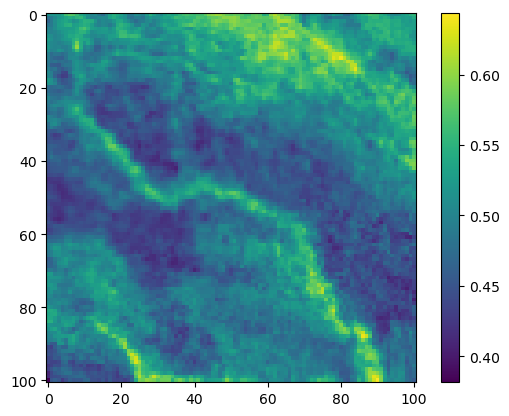

In [9]:
for i in range(0, 1):
    plt.imshow(ndvi_tens_norm[i].numpy())
    plt.colorbar()
    plt.show()
    

## Canopy cover

In [10]:
# Using rasterio
with rasterio.open(canopy_path) as canopy:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    canopy_stack = canopy.read([i for i in range(1, canopy.count + 1)])

print(canopy_stack.shape)

(10103, 101, 101)


In [11]:
# Convert the numpy array to a PyTorch tensor, which is the format required for training the model
canopy_tens = torch.from_numpy(canopy_stack)
print(canopy_tens.shape)

# Print the mean, max, and min values of the NDVI tensor
print("Mean = ", torch.mean(canopy_tens))
canopy_max = torch.max(canopy_tens)
canopy_min = torch.min(canopy_tens)
print("Max = ", canopy_max)
print("Min = ", canopy_min)

# Normalizing the data
canopy_tens_norm = (canopy_tens - canopy_min) / (canopy_max - canopy_min)
print("Mean = ", torch.mean(canopy_tens_norm))
print("Max = ", torch.max(canopy_tens_norm))
print("Min = ", torch.min(canopy_tens_norm))


torch.Size([10103, 101, 101])
Mean =  tensor(44.3548)
Max =  tensor(82.5000)
Min =  tensor(0.)
Mean =  tensor(0.5376)
Max =  tensor(1.)
Min =  tensor(0.)


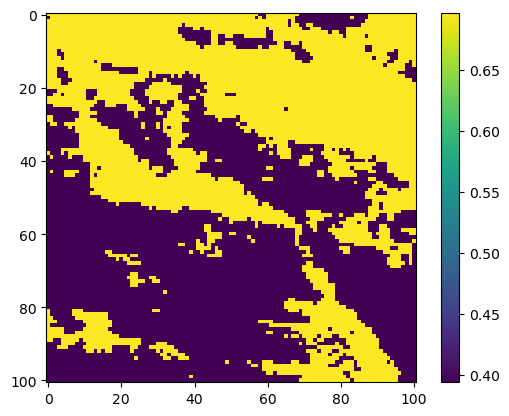

In [12]:
for i in range(0, 1):
    plt.imshow(canopy_tens_norm[i].numpy())
    plt.colorbar()
    plt.show()

## Herbaceous vegetation

In [13]:
# Using rasterio
with rasterio.open(herby_path) as herby:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    herby_stack = herby.read([i for i in range(1, herby.count + 1)])

print(herby_stack.shape)

(10103, 101, 101)


In [14]:
# Convert the numpy array to a PyTorch tensor, which is the format required for training the model
herby_tens = torch.from_numpy(herby_stack)
print(herby_tens.shape)

# Print the mean, max, and min values of the NDVI tensor
print("Mean = ", torch.mean(herby_tens))
herby_max = torch.max(herby_tens)
herby_min = torch.min(herby_tens)
print("Max = ", herby_max)
print("Min = ", herby_min)

# Normalizing the data
herby_tens_norm = (herby_tens - herby_min) / (herby_max - herby_min)
print("Mean = ", torch.mean(herby_tens_norm))
print("Max = ", torch.max(herby_tens_norm))
print("Min = ", torch.min(herby_tens_norm))


torch.Size([10103, 101, 101])
Mean =  tensor(0.8069)
Max =  tensor(1.)
Min =  tensor(0.)
Mean =  tensor(0.8069)
Max =  tensor(1.)
Min =  tensor(0.)


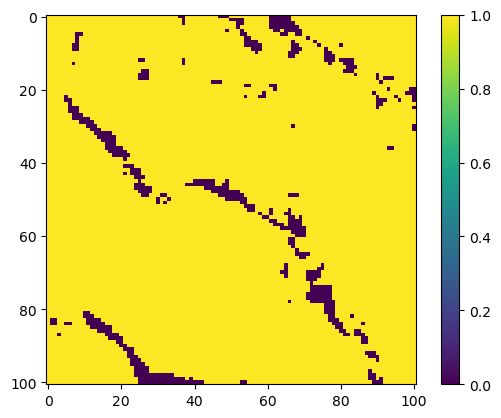

In [15]:
for i in range(0, 1):
    plt.imshow(herby_tens_norm[i])
    plt.colorbar()
    plt.show()

## Slope

In [16]:
# Using rasterio
with rasterio.open(slope_path) as slope:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    slope_stack = slope.read([i for i in range(1, slope.count + 1)])

print(slope_stack.shape)

(10103, 101, 101)


In [17]:
# Convert the numpy array to a PyTorch tensor, which is the format required for training the model
slope_tens = torch.from_numpy(slope_stack)
print(slope_tens.shape)

# Print the mean, max, and min values of the NDVI tensor
print("Mean = ", torch.mean(slope_tens))
slope_max = torch.max(slope_tens)
slope_min = torch.min(slope_tens)
print("Max = ", slope_max)
print("Min = ", slope_min)

# Normalizing the data
slope_tens_norm = (slope_tens - slope_min) / (slope_max - slope_min)
print("Mean = ", torch.mean(slope_tens_norm))
print("Max = ", torch.max(slope_tens_norm))
print("Min = ", torch.min(slope_tens_norm))


torch.Size([10103, 101, 101])
Mean =  tensor(0.7779)
Max =  tensor(12.2981)
Min =  tensor(0.0006)
Mean =  tensor(0.0632)
Max =  tensor(1.)
Min =  tensor(0.)


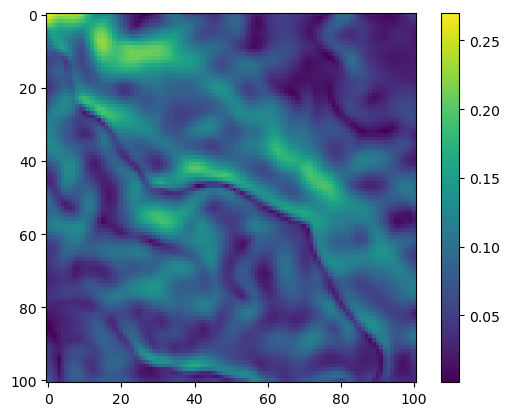

In [18]:
for i in range(0, 1):
    plt.imshow(slope_tens_norm[i])
    plt.colorbar()
    plt.show()

## Presence records - target of model

This is what the model is trying to predict, which is the location of the next step.

In [19]:
# Using rasterio
with rasterio.open(pres_path) as pres:
    # Read all layers/channels into a single numpy array
    # rasterio indexes channels starting from 1, hence the range is 1 to src.count + 1
    pres_stack = pres.read([i for i in range(1, pres.count + 1)])

print(pres_stack.shape)

(10103, 101, 101)


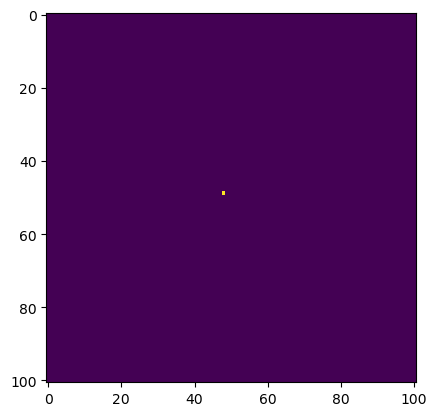

In [20]:
for i in range(0, 1):
    plt.imshow(pres_stack[i])
    plt.show()

In [22]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cpu device


### Combine the spatial layers into channels

In [23]:
# Stack the channels along a new axis; here, 1 is commonly used for the channel axis in PyTorch
combined_stack = torch.stack([ndvi_tens_norm, canopy_tens_norm, herby_tens_norm, slope_tens_norm], dim=1)
combined_stack
print(combined_stack.shape)

torch.Size([10103, 4, 101, 101])


From the size we can see that there are 10103 samples (steps), 4 channels (layers = covariates) and 101x101 pixels.

## Defining data sets and data loaders

### Creating a dataset class

As convolutional layers require images as inputs, we convert the scalar information such as the hour of the day and the day of the year into a 2D image, with the same values for all pixels. We do the same with the previous bearing, and could also include other movement covariates such as previous step lengths.

In [24]:
class buffalo_data(Dataset):

    def __init__(self):
        # data loading. Here we are just using the combined_stack as the spatial covariates
        self.spatial_data_x = combined_stack

        # the scalar data that will be converted to spatial data and added as channels to the spatial covariates
        self.scalar_to_grid_data = torch.from_numpy(buffalo_df[['hour_t2_sin', 'hour_t2_cos', 'yday_t2_sin', 'yday_t2_cos']].values).float()

        # the bearing data that will be added as a channel to the spatial covariates
        self.bearing_x = torch.from_numpy(buffalo_df[['bearing_tm1']].values).float()

        # the target data
        self.target = torch.tensor(pres_stack)

        # number of samples
        self.n_samples = self.spatial_data_x.shape[0]

    def __len__(self):
        # allows for the use of len() function
        return self.n_samples

    def __getitem__(self, index):
        # allows for indexing of the dataset
        return self.spatial_data_x[index], self.scalar_to_grid_data[index], self.bearing_x[index], self.target[index]

Now we can create an instance of the dataset class and check that is working as expected.

In [32]:
# instantiate the dataset
dataset = buffalo_data()

# check the number of samples in the dataset
print(dataset.n_samples)

# check the shape of the spatial covariates
features1, features2, features3, labels = dataset[:]
print(features1.shape)
print(features2.shape)
print(features3.shape)
print(labels.shape)


10103
torch.Size([10103, 4, 101, 101])
torch.Size([10103, 4])
torch.Size([10103, 1])
torch.Size([10103, 101, 101])


### Split into training, validation and test sets

In [34]:
training_split = 0.8 # 80% of the data will be used for training
validation_split = 0.1 # 10% of the data will be used for validation (deciding when to stop training)
test_split = 0.1 # 10% of the data will be used for testing (model evaluation)

dataset_train, dataset_val, dataset_test = torch.utils.data.random_split(dataset, [training_split, validation_split, test_split])
print("Number of training samples: ", len(dataset_train))
print("Number of validatiom samples: ", len(dataset_val))
print("Number of testing samples: ", len(dataset_test))

Number of training samples:  8083
Number of validatiom samples:  1010
Number of testing samples:  1010


### Create dataloaders

The DataLoader in PyTorch wraps an iterable around the Dataset to enable easy access to the samples.

In [35]:
bs = 32 # batch size
dataloader_train = DataLoader(dataset=dataset_train, batch_size=bs, shuffle=True)
dataloader_val = DataLoader(dataset=dataset_val, batch_size=bs, shuffle=True)
dataloader_test = DataLoader(dataset=dataset_test, batch_size=bs, shuffle=True)

In [37]:
# Display image and label.
# next(iter(dataloader_train)) returns the next batch of the training data
features1, features2, features3, labels = next(iter(dataloader_train))
print(f"Feature 1 batch shape: {features1.size()}")
print(f"Feature 2 batch shape: {features2.size()}")
print(f"Feature 3 batch shape: {features3.size()}")
print(f"Labels batch shape: {labels.size()}")

Feature 1 batch shape: torch.Size([32, 4, 101, 101])
Feature 2 batch shape: torch.Size([32, 4])
Feature 3 batch shape: torch.Size([32, 1])
Labels batch shape: torch.Size([32, 101, 101])


# Define the model

Deep learning can be considered as a sequence of **blocks**, each of which perform some (typically nonlinear) transformation on input data to produce some output. Providing each block has the appropriate inputs, they can be combined to build a larger network that is capable of achieving complex and abstract transformations and can be used to represent complex processes.

A block is modular component of a neural network, in our case defined as a Python class (type of object with certain functionality described by its definition) inheriting from torch.nn.Module in PyTorch. A block encapsulates a sequence of operations, including layers (such as fully connected layers or convolutional layers) and activation functions, to process input data. Each block has a forward method (i.e. instructions) that defines the data flow through the network during inference or training.

## Convolutional block for the habitat selection subnetwork

This block is a convolutional layer that takes in the spatial covariates (including the layers created from the scalar values such as time), goes through a series of convolution operations amd ReLU activation functions and outputs a feature map, which is the habitat selection probability surface.

In [114]:
class Conv2d_block_spatial(nn.Module):
    def __init__(self, params):
        super(Conv2d_block_spatial, self).__init__()
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        self.conv2d = nn.Sequential(
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.output_channels, out_channels=1, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        )

    def forward(self, x):

        # print("Shape before squeeze:", self.conv2d(x).shape) # Debugging print
        conv2d_spatial = self.conv2d(x).squeeze(dim = 1)
    
        # normalise to sum to 1
        # print("Shape before logsumexp:", conv2d_spatial.shape) # Debugging print
        conv2d_spatial = conv2d_spatial - torch.logsumexp(conv2d_spatial, dim = (1, 2), keepdim = True)

        return conv2d_spatial
    

## Convolutional block for the movement subnetwork

This block is also convolutional layer, with the same inputs, 

In [ ]:

# Convolutional block for the habitat selection subnetwork

class Conv2d_block_toFC(nn.Module):
    def __init__(self, params):
        super(Conv2d_block_toFC, self).__init__()
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        self.kernel_size_mp = params.kernel_size_mp
        self.stride_mp = params.stride_mp
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        self.conv2d = nn.Sequential(
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        nn.Flatten())

    def forward(self, x):
        return self.conv2d(x)





class FCN_block_all_movement(nn.Module):
    def __init__(self, params):
        super(FCN_block_all_movement, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_all = params.dense_dim_in_all
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.num_movement_params = params.num_movement_params
        self.dropout = params.dropout

        self.ffn = nn.Sequential(
            nn.Linear(self.dense_dim_in_all, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.num_movement_params)
        )

    def forward(self, x):
        return self.ffn(x)



##################################################
# Mixture of two Gamma and von Mises distributions with the von Mises mu parameters allowed to vary
##################################################

class Params_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Params_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.pixel_size = params.pixel_size
        self.center = self.image_dim // 2
        y, x = np.indices((self.image_dim, self.image_dim))
        self.distance_layer = torch.from_numpy(np.sqrt((self.pixel_size*(x - self.center))**2 + (self.pixel_size*(y - self.center))**2))
        # change the centre cell to the average distance from the centre to the edge of the pixel
        self.distance_layer[self.center, self.center] = 0.56*self.pixel_size # average distance from the centre to the perimeter of the pixel (accounting for longer distances at the corners)
        # self.bearing_layer = torch.from_numpy(np.arctan2(y - self.center, x - self.center))
        self.bearing_layer = torch.from_numpy(np.arctan2(self.center - y, x - self.center))
        self.device = params.device


    # Gamma desnities for the mixture distribution
    def gamma_density(self, x, shape, scale):
        # Ensure all tensors are on the same device as x
        shape = shape.to(x.device)
        scale = scale.to(x.device)
        return -1*torch.lgamma(shape) -shape*torch.log(scale) + (shape - 1)*torch.log(x) - x/scale

    # von Mises densities for the mixture distribution
    def vonmises_density(self, x, kappa, vm_mu):
        # Ensure all tensors are on the same device as x
        kappa = kappa.to(x.device)
        vm_mu = vm_mu.to(x.device)
        return kappa*torch.cos(x - vm_mu) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa)))


    def forward(self, x, bearing):

        # parameters of the first mixture distribution
        gamma_shape1 = torch.exp(x[:, 0]).unsqueeze(0).unsqueeze(0)
        gamma_shape1 = gamma_shape1.repeat(self.image_dim, self.image_dim, 1)
        gamma_shape1 = gamma_shape1.permute(2, 0, 1)

        gamma_scale1 = torch.exp(x[:, 1]).unsqueeze(0).unsqueeze(0)
        gamma_scale1 = gamma_scale1.repeat(self.image_dim, self.image_dim, 1)
        gamma_scale1 = gamma_scale1.permute(2, 0, 1)

        gamma_weight1 = torch.exp(x[:, 2]).unsqueeze(0).unsqueeze(0)
        gamma_weight1 = gamma_weight1.repeat(self.image_dim, self.image_dim, 1)
        gamma_weight1 = gamma_weight1.permute(2, 0, 1)

        # parameters of the second mixture distribution
        gamma_shape2 = torch.exp(x[:, 3]).unsqueeze(0).unsqueeze(0)
        gamma_shape2 = gamma_shape2.repeat(self.image_dim, self.image_dim, 1)
        gamma_shape2 = gamma_shape2.permute(2, 0, 1)

        gamma_scale2 = torch.exp(x[:, 4]).unsqueeze(0).unsqueeze(0)
        gamma_scale2 = gamma_scale2 * 500 ### to transform the scale parameter to be near 1
        gamma_scale2 = gamma_scale2.repeat(self.image_dim, self.image_dim, 1)
        gamma_scale2 = gamma_scale2.permute(2, 0, 1)

        gamma_weight2 = torch.exp(x[:, 5]).unsqueeze(0).unsqueeze(0)
        gamma_weight2 = gamma_weight2.repeat(self.image_dim, self.image_dim, 1)
        gamma_weight2 = gamma_weight2.permute(2, 0, 1)

        # Apply softmax to the weights
        gamma_weights = torch.stack([gamma_weight1, gamma_weight2], dim=0)
        gamma_weights = torch.nn.functional.softmax(gamma_weights, dim=0)
        gamma_weight1 = gamma_weights[0]
        gamma_weight2 = gamma_weights[1]

        # calculation of Gamma densities
        gamma_density_layer1 = self.gamma_density(self.distance_layer, gamma_shape1, gamma_scale1).to(device)
        gamma_density_layer2 = self.gamma_density(self.distance_layer, gamma_shape2, gamma_scale2).to(device)

        # combining both densities to create a mixture distribution using logsumexp
        logsumexp_gamma_corr = torch.max(gamma_density_layer1, gamma_density_layer2)
        gamma_density_layer = logsumexp_gamma_corr + torch.log(gamma_weight1 * torch.exp(gamma_density_layer1 - logsumexp_gamma_corr) + gamma_weight2 * torch.exp(gamma_density_layer2 - logsumexp_gamma_corr))
        # print(torch.sum(gamma_density_layer))
        # print(torch.sum(torch.exp(gamma_density_layer)))

        # normalise the gamma weights so they sum to 1
        # gamma_density_layer = gamma_density_layer - torch.logsumexp(gamma_density_layer, dim = (1, 2), keepdim = True)

        # print(torch.sum(gamma_density_layer))
        # print(torch.sum(torch.exp(gamma_density_layer)))


        ## Von Mises Distributions

        # calculate the new bearing from the turning angle
        # takes in the bearing from the previous step and adds the turning angle
        bearing_new1 = x[:, 6] + bearing[:, 0]
        # bearing_new1 = 0.0 + bearing[:, 0]

        # print('Bearing.shape ', bearing.shape)
        # print('Bearing[:, 0].shape ', bearing[:, 0].shape)
        # print('Bearing[:, 0] ', bearing[:, 0])
        # the new bearing becomes the mean of the von Mises distribution
        # the estimated parameter [x:, 7] is the turning angle of the next step
        # which is always in reference to the input bearing
        vonmises_mu1 = bearing_new1.unsqueeze(0).unsqueeze(0)
        vonmises_mu1 = vonmises_mu1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_mu1 = vonmises_mu1.permute(2, 0, 1)

        # parameters of the first von Mises distribution
        vonmises_kappa1 = torch.exp(x[:, 7]).unsqueeze(0).unsqueeze(0)
        vonmises_kappa1 = vonmises_kappa1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_kappa1 = vonmises_kappa1.permute(2, 0, 1)

        vonmises_weight1 = torch.exp(x[:, 8]).unsqueeze(0).unsqueeze(0)
        vonmises_weight1 = vonmises_weight1.repeat(self.image_dim, self.image_dim, 1)
        vonmises_weight1 = vonmises_weight1.permute(2, 0, 1)

        # vm_mu and weight for the second von Mises distribution
        bearing_new2 = x[:, 9] + bearing[:, 0]
        # bearing_new2 = torch.pi + bearing[:, 0]
        # bearing_new2 = -torch.pi + bearing[:, 0]

        vonmises_mu2 = bearing_new2.unsqueeze(0).unsqueeze(0)
        vonmises_mu2 = vonmises_mu2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_mu2 = vonmises_mu2.permute(2, 0, 1)

        # parameters of the second von Mises distribution
        vonmises_kappa2 = torch.exp(x[:, 10]).unsqueeze(0).unsqueeze(0)
        vonmises_kappa2 = vonmises_kappa2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_kappa2 = vonmises_kappa2.permute(2, 0, 1)

        vonmises_weight2 = torch.exp(x[:, 11]).unsqueeze(0).unsqueeze(0)
        vonmises_weight2 = vonmises_weight2.repeat(self.image_dim, self.image_dim, 1)
        vonmises_weight2 = vonmises_weight2.permute(2, 0, 1)

        # Apply softmax to the weights
        vonmises_weights = torch.stack([vonmises_weight1, vonmises_weight2], dim=0)
        vonmises_weights = torch.nn.functional.softmax(vonmises_weights, dim=0)
        vonmises_weight1 = vonmises_weights[0]
        vonmises_weight2 = vonmises_weights[1]

        # calculation of von Mises densities
        vonmises_density_layer1 = self.vonmises_density(self.bearing_layer, vonmises_kappa1, vonmises_mu1).to(device)
        vonmises_density_layer2 = self.vonmises_density(self.bearing_layer, vonmises_kappa2, vonmises_mu2).to(device)

        # combining both densities to create a mixture distribution using the logsumexp trick
        logsumexp_vm_corr = torch.max(vonmises_density_layer1, vonmises_density_layer2)
        vonmises_density_layer = logsumexp_vm_corr + torch.log(vonmises_weight1 * torch.exp(vonmises_density_layer1 - logsumexp_vm_corr) + vonmises_weight2 * torch.exp(vonmises_density_layer2 - logsumexp_vm_corr))
        # print(torch.sum(vonmises_density_layer))
        # print(torch.sum(torch.exp(vonmises_density_layer)))

        # normalise so the densities sum to 1 when exponentiated
        # vonmises_density_layer = vonmises_density_layer - torch.logsumexp(vonmises_density_layer, dim = (1, 2), keepdim = True)
        # print(torch.sum(vonmises_density_layer))
        # print(torch.sum(torch.exp(vonmises_density_layer)))

        # combining the two distributions
        movement_grid = gamma_density_layer + vonmises_density_layer # Gamma and von Mises densities are on the log-scale
        # print('Movement grid ', torch.sum(movement_grid))
        # print(torch.sum(torch.exp(movement_grid)))

        # normalise before combining with the habitat predictions
        movement_grid = movement_grid - torch.logsumexp(movement_grid, dim = (1, 2), keepdim = True)

        # print('Movement grid norm ', torch.sum(movement_grid))
        # print(torch.sum(torch.exp(movement_grid)))

        return movement_grid


class Scalar_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Scalar_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.device = params.device

    def forward(self, x):
        num_scalars = x.shape[1]
        scalar_map = x.view(x.shape[0], num_scalars, 1, 1).expand(x.shape[0], num_scalars, self.image_dim, self.image_dim)
        return scalar_map


# Define the model as a combination of the blocks

class ConvJointModel(nn.Module):
    def __init__(self, params):
        super(ConvJointModel, self).__init__()

        # instantiate the blocks
        self.scalar_grid_output = Scalar_to_Grid_Block(params)
        self.conv_habitat = Conv2d_block_spatial(params)
        self.conv_movement = Conv2d_block_toFC(params)
        self.fcn_movement_all = FCN_block_all_movement(params)
        self.movement_grid_output = Params_to_Grid_Block(params)
        self.device = params.device

    def forward(self, x):
        spatial_data_x = x[0]
        scalars_to_grid = x[1]
        bearing_x = x[2]

        # SCALAR DATA
        # convert the scalar data to grids (spatial layers)
        scalar_grids = self.scalar_grid_output(scalars_to_grid)
        # concatenate the spatial data with the scalar grids
        all_spatial = torch.cat([spatial_data_x, scalar_grids], dim = 1)
        # print(f"Shape after scalar grid: {all_spatial.shape}")  # Debugging print

        # HABITAT SELECTION
        # convolutional layers to extract spatial features that are important for habitat selection
        output_habitat = self.conv_habitat(all_spatial)
        # print(f"Shape after CNN habitat: {output_habitat.shape}")  # Debugging print

        # MOVEMENT
        # convolutional layers to extract spatial features that are important for movement
        conv_movement = self.conv_movement(all_spatial)
        # print(f"Shape after CNN to FC movement: {conv_movement.shape}")  # Debugging print

        # fully connected layers to process spatial and non-spatial features for movement
        output_movement = self.fcn_movement_all(conv_movement)
        # print(f"Shape after fcn_movement_all: {output_movement.shape}")  # Debugging print

        # convert the parameters of the movement distribution to a grid
        output_movement = self.movement_grid_output(output_movement, bearing_x)
        # print(f"Shape after CNN movement: {output_movement.shape}")  # Debugging print

        # stack the habitat and movement predictions (but do not combine yet)
        output = torch.stack((output_habitat, output_movement), dim = -1)
        return output


# Set the parameters for the model which will be specified in a dictionary

class ModelParams():
    def __init__(self, dict_params):
        self.batch_size = dict_params["batch_size"]
        self.image_dim = dict_params["image_dim"]
        self.pixel_size = dict_params["pixel_size"]
        self.batch_size = dict_params["batch_size"]
        self.dim_in_nonspatial_to_grid = dict_params["dim_in_nonspatial_to_grid"]
        self.dense_dim_in_nonspatial = dict_params["dense_dim_in_nonspatial"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.dense_dim_in_all = dict_params["dense_dim_in_all"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.input_channels = dict_params["input_channels"]
        self.output_channels = dict_params["output_channels"]
        self.kernel_size = dict_params["kernel_size"]
        self.stride = dict_params["stride"]
        self.kernel_size_mp = dict_params["kernel_size_mp"]
        self.stride_mp = dict_params["stride_mp"]
        self.padding = dict_params["padding"]
        self.image_dim = dict_params["image_dim"]
        self.num_movement_params = dict_params["num_movement_params"]
        self.dropout = dict_params["dropout"]
        self.device = dict_params["device"]


## Instantiate the model

In [31]:
params_dict = {"batch_size": 32,
               "image_dim": 101, #number of pixels along the edge of each local patch/image
               "pixel_size": 25, #number of metres along the edge of a pixel
               "dim_in_nonspatial_to_grid": 4, #the number of scalar predictors that are converted to a grid and appended to the spatial features
               "dense_dim_in_nonspatial": 4, #change this to however many other scalar predictors you have (bearing, velocity etc)
               "dense_dim_hidden": 128, #number of nodes in the hidden layers
               "dense_dim_out": 128, #number of nodes in the output of the fully connected block (FCN)
               "dense_dim_in_all": 2500,# + 128, #number of inputs entering the fully connected block once the nonspatial features have been concatenated to the spatial features
               "input_channels": 4 + 4, #number of spatial layers in each image + number of scalar layers that are converted to a grid
               "output_channels": 4, #number of filters to learn
               "kernel_size": 3, #the size of the 2D moving windows / kernels that are being learned
               "stride": 1, #the stride used when applying the kernel.  This reduces the dimension of the output if set to greater than 1
               "kernel_size_mp": 2, #the size of the kernel that is used in max pooling operations
               "stride_mp": 2, #the stride that is used in max pooling operations
               "padding": 1, #the amount of padding to apply to images prior to applying the 2D convolution
               "num_movement_params": 12, #number of parameters used to parameterise the movement kernel
               "dropout": 0.1,
               "device": device
               }

params = ModelParams(params_dict)
model = ConvJointModel(params).to(device)
# print(model)

## Testing the scalar to grid function

torch.Size([32, 4])
tensor([-0.8660, -0.5000, -0.8867, -0.4623])
torch.Size([32, 4, 101, 101])


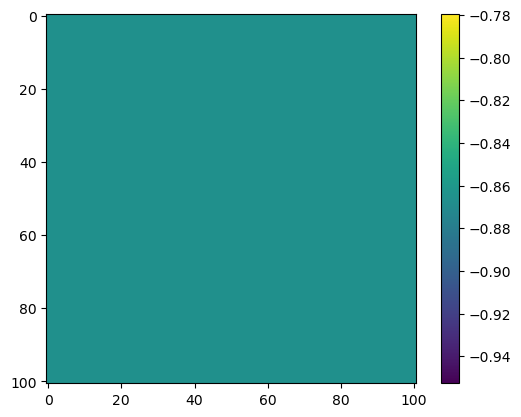

In [32]:
# test_scalars = torch.tensor([[2.0, 1.0]], device=device)
test_data = x1, x2, x3, labels = next(iter(dataloader_test))
test_scalars = x2
print(test_scalars.shape)
print(test_scalars[0,:])

test_block = Scalar_to_Grid_Block(params)
scalar_maps = test_block(test_scalars)
# print(scalar_maps)
print(scalar_maps.shape)

# should show the same value across the grid
plt.imshow(scalar_maps[0, 0])
plt.colorbar()
plt.show()

### Create some random covariates to test the model

In [33]:
test_batch = 1
x1 = (torch.rand(test_batch, 4, 101, 101, device=device)) #spatial data
x2 = (torch.rand(test_batch, 4, device=device)) #other scalar covariates
x3 = (torch.rand(test_batch, 1, device=device)) # bearing
# x4 = (torch.rand(test_batch, 1, device=device)) #bearing
# y = (torch.rand(1, 1, 101, 101, device=device)) #spatial data
print(x2)
print(x3)
# print(x4)

# plot the results of the movement density as an image
# plt.imshow(x1.detach().cpu().numpy()[0, 0, :,:])
# plt.colorbar()
# plt.show()

# synth_ds = TensorDataset(x1, x2, y)
# synth_dl = DataLoader(synth_ds, batch_size=1, shuffle=True)

tensor([[0.9131, 0.6609, 0.0949, 0.9536]])
tensor([[0.5027]])


torch.Size([1, 101, 101, 2])


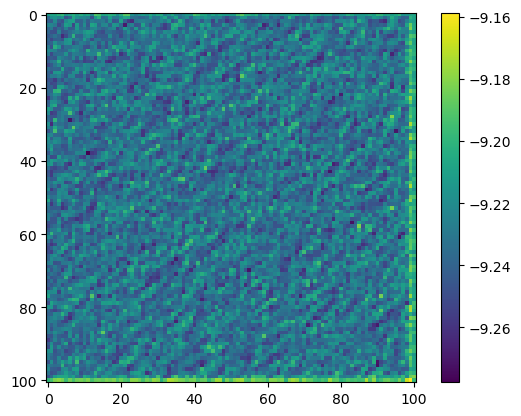

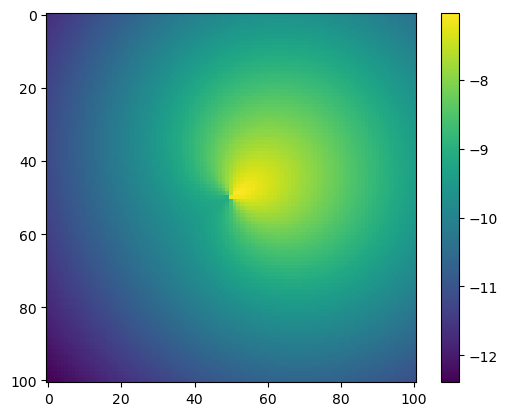

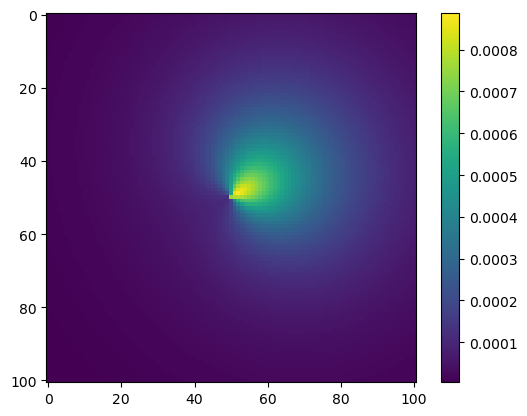

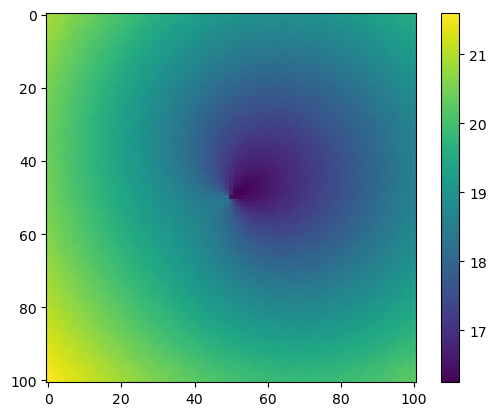

In [34]:
#Test that the model runs
# x1, x2 = synth_ds[0][0], synth_ds[0][1]
test = model((x1, x2, x3))
print(test.shape)
# print(test)

# plot the results of the habitat density as an image
plt.imshow(test.detach().cpu().numpy()[0,:,:,0])
plt.colorbar()
plt.show()

# plot the results of the movement density as an image
plt.imshow(test.detach().cpu().numpy()[0,:,:,1])
plt.colorbar()
plt.show()

# plot the results of the exp movement density as an image
plt.imshow(np.exp(test.detach().cpu().numpy()[0,:,:,1]))
plt.colorbar()
plt.show()

test_cat = -1 * (test[:, :, :, 0] + test[:, :, :, 1])
# test_cat = torch.log(test[:, :, :, 0]*test[:, :, :, 1])
# test_cat = -1 * test[:, :, :, 0] * torch.exp(test[:, :, :, 1])

plt.imshow(test_cat.detach().cpu().numpy()[0,:,:])
plt.colorbar()
plt.show()

### Testing the movement parameter block with known Gamma and von Mises parameters

tensor([[[-11.1784, -11.1407, -11.1036,  ..., -10.9295, -10.9666, -11.0044],
         [-11.1288, -11.0908, -11.0535,  ..., -10.8794, -10.9168, -10.9550],
         [-11.0797, -11.0414, -11.0038,  ..., -10.8298, -10.8675, -10.9060],
         ...,
         [-11.0797, -11.0414, -11.0038,  ..., -10.8298, -10.8675, -10.9060],
         [-11.1288, -11.0908, -11.0535,  ..., -10.8794, -10.9168, -10.9550],
         [-11.1784, -11.1407, -11.1036,  ..., -10.9295, -10.9666, -11.0044]]],
       dtype=torch.float64)
torch.Size([1, 101, 101])


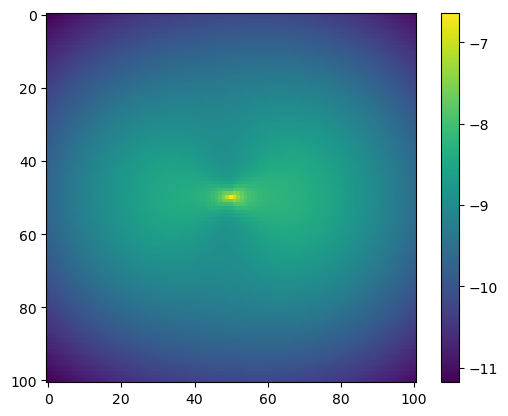

In [35]:
test_bearing = torch.tensor([[0.0]], device=device)

test_block = Params_to_Grid_Block(params)
# movement_density = test_block(torch.rand(1, 4, device=device))
# provide a tensor of shape (batch_size, 4) where the 4 columns are the parameters of the gamma and von mises distributions
# providing values in log space as the values are exponentiated in the forward pass

# for single Gamma and von Mises distributions
# movement_density = test_block(torch.tensor([[np.log(0.5), np.log(200/500), # gamma shape and scale
#                                              0.0, np.log(1.5)]], # von Mises mu and kappa
#                                            device=device), test_bearing)

# for the mixture
movement_density = test_block(torch.tensor([[np.log(0.5), np.log(200), np.log(0.25), # gamma 1 - shape, scale and weight
                                             np.log(2.5), np.log(300/500), np.log(0.75), # gamma 2 - shape, scale and weight
                                             0.0, np.log(1), np.log(0.75),
                                             -np.pi, np.log(1.5), np.log(0.25)]], device=device), test_bearing)

# providing values as the model sees them
# movement_density = test_block(torch.tensor([[-.5, -.5, -.5, -.5]], device=device))
print(movement_density)
print(movement_density.shape)

# plot the results of the movement density as an image
plt.imshow(movement_density.detach().cpu().numpy()[0])
plt.colorbar()
plt.show()

## Loss function and optimizer

In [36]:
# Custom loss function to work with the two heatmaps that the model outputs

class negativeLogLikeLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(negativeLogLikeLoss, self).__init__()
        assert reduction in ['mean', 'sum', 'none'], "reduction should be 'mean', 'sum', or 'none'"
        self.reduction = reduction  # Assign reduction to self.reduction

    def forward(self, predict, target):
        predict_prod = predict[:, :, :, 0] + predict[:, :, :, 1]          # elementwise summation of the two heatmaps - for log-densities
        # predict_prod = predict[:, :, :, 0]*predict[:, :, :, 1]          # elementwise product of the two heatmaps
        # predict_prod = predict_prod/torch.sum(predict_prod)             # normalise the product of the two heatmaps
        # negLogLike = -1*(predict_prod * target)

        # Check for NaNs in the product
        if torch.isnan(predict_prod).any():
            print("NaNs detected in predict_prod")
            print("predict_prod:", predict_prod)
            raise ValueError("NaNs detected in predict_prod")

        # predict_prod = predict_prod / torch.sum(predict_prod)  # normalise the product of the two heatmaps

        # Check for NaNs after normalization
        # if torch.isnan(predict_prod).any():
        #     print("NaNs detected after normalization")
        #     print("predict_prod:", predict_prod)
        #     raise ValueError("NaNs detected after normalization")

        negLogLike = -1 * (predict_prod * target)
        # negLogLike = -1 * torch.log(predict_prod * target)

        # Check for NaNs in the negative log likelihood
        if torch.isnan(negLogLike).any():
            print("NaNs detected in negLogLike")
            print("negLogLike:", negLogLike)
            raise ValueError("NaNs detected in negLogLike")

        if self.reduction == 'mean':
            return torch.mean(negLogLike)
        elif self.reduction == 'sum':
            return torch.sum(negLogLike)
        elif self.reduction == 'none':
            return negLogLike
        return negLogLike

### Early stopping code

In [37]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Instantiate the model

In [38]:
params = ModelParams(params_dict)
model = ConvJointModel(params).to(device)
# print(model)

# # save the model structure
# torch.save(model, 'CNN_model_global.pth')

learning_rate = 1e-4
loss_fn = negativeLogLikeLoss(reduction='mean')

# path to save the model weights
path_save_weights = f'model_checkpoints/checkpoint_CNN_global_buffalo{buffalo_id}_TAmix_bearing-rev_adj_hab-covs_grid-only_{today_date}.pt'

optimiser = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', factor=0.1, patience=5)
early_stopping = EarlyStopping(patience=10, verbose=True, path = path_save_weights) # , delta=early_stopping_delta

torch.Size([1, 101, 101, 2])


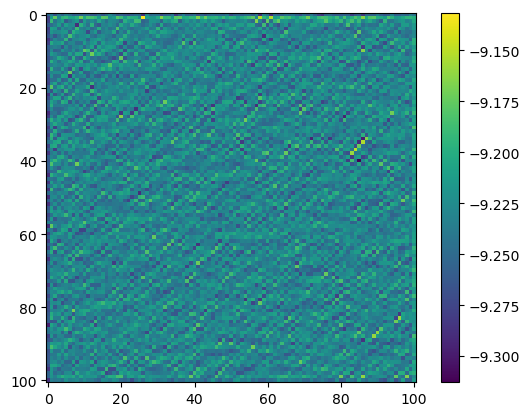

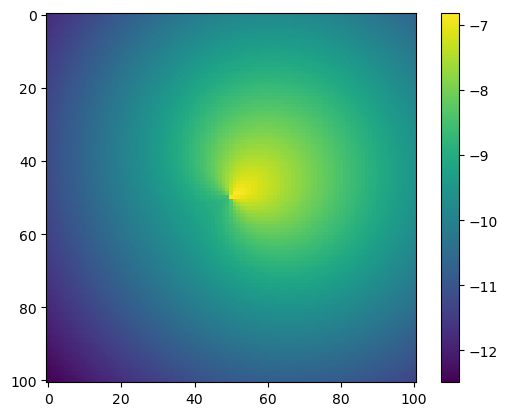

0.9999999999999999


In [39]:
# 1. Set the model in evaluation mode
model.eval()

#Test that the model runs
# x1, x2 = synth_ds[0][0], synth_ds[0][1]
test = model((x1, x2, x3))
print(test.shape)
# print(test)

# # plot the results of the habitat density as an image
plt.imshow(test.detach().cpu().numpy()[0,:,:,0])
plt.colorbar()
plt.show()

# # plot the results of the movement density as an image
plt.imshow(test.detach().cpu().numpy()[0,:,:,1])
plt.colorbar()
plt.show()

print(np.sum(np.exp(test.detach().cpu().numpy()[0,:,:,1])))

# test_cat = test[:, :, :, 0]*test[:, :, :, 1]
# test_cat = test_cat/torch.sum(test_cat)
# print(test_cat.shape)

# test_cat = -1 * torch.log(test[:, :, :, 0]*test[:, :, :, 1] )
# print(test_cat.shape)

# plt.imshow(test_cat.detach().numpy()[0,:,:])
# plt.colorbar()
# plt.show()

## Functions for recovering the hour and yday from the sin and cosine terms

In [40]:
def recover_hour(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    hour = (12 * theta) / np.pi % 24
    return hour

def recover_yday(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    yday = (365 * theta) / (2 * np.pi)  % 365
    return yday

## Pull out some covariates to visualise model training

Hour: 9
Day of the year: 225
Bearing (radians): -1.4869709014892578
Bearing (degrees): 274
The coordinates of the element that is 1 are (row, column): (70, 62)


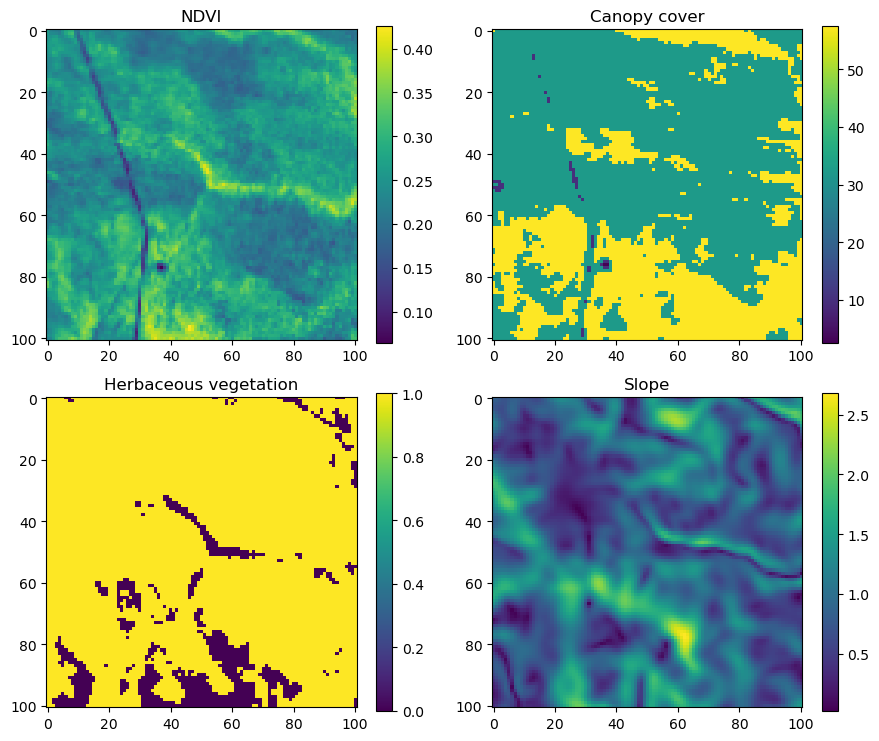

In [41]:
iteration_index = 25

# 1. Set the model in evaluation mode
model.eval()

# test_data = x1_plot, x2_plot, x3_plot, labels = next(iter(dataloader_test))
# test_covs = x1_plot

# Get data for the specific index from dataloader_test's dataset
test_data = x1_plot, x2_plot, x3_plot, labels = dataloader_test.dataset[iteration_index]

# Reshape to add a batch dimension
x1_plot = x1_plot.unsqueeze(0).to(device)
x2_plot = x2_plot.unsqueeze(0).to(device)
x3_plot = x3_plot.unsqueeze(0).to(device)
labels = labels.unsqueeze(0).to(device)

test_covs = x1_plot

# Returning data to natural scale
# NDVI
ndvi_norm = test_covs.detach().cpu()[0, 0, :, :]
ndvi_natural = (ndvi_norm * (ndvi_max - ndvi_min)) + ndvi_min
# Canopy cover
canopy_norm = test_covs.detach().cpu()[0, 1, :, :]
canopy_natural = (canopy_norm * (canopy_max - canopy_min)) + canopy_min
# Herbaceous vegetation
herby_norm = test_covs.detach().cpu()[0, 2, :, :]
herby_natural = (herby_norm * (herby_max - herby_min)) + herby_min
# Slope
slope_norm = test_covs.detach().cpu()[0, 3, :, :]
slope_natural = (slope_norm * (slope_max - slope_min)) + slope_min

# Pull out the scalars
hour_t2_sin = x2_plot.detach().cpu().numpy()[0,0]
hour_t2_cos = x2_plot.detach().cpu().numpy()[0,1]
yday_t2_sin = x2_plot.detach().cpu().numpy()[0,2]
yday_t2_cos = x2_plot.detach().cpu().numpy()[0,3]
bearing = x3_plot.detach().cpu().numpy()[0,0]

hour_t2 = recover_hour(hour_t2_sin, hour_t2_cos)
hour_t2_integer = int(hour_t2)  # Convert to integer
print(f'Hour: {hour_t2_integer}')

yday_t2 = recover_yday(yday_t2_sin, yday_t2_cos)
yday_t2_integer = int(yday_t2)  # Convert to integer
print(f'Day of the year: {yday_t2_integer}')

bearing_degrees = np.degrees(bearing) % 360
bearing_degrees = round(bearing_degrees, 1)  # Round to 2 decimal places
bearing_degrees = int(bearing_degrees)  # Convert to integer
print(f'Bearing (radians): {bearing}')
print(f'Bearing (degrees): {bearing_degrees}')

# Find the coordinates of the element that is 1
target = labels.detach().cpu().numpy()[0,:,:]
coordinates = np.where(target == 1)
# Extract the coordinates
row, column = coordinates[0][0], coordinates[1][0]
print(f"The coordinates of the element that is 1 are (row, column): ({row}, {column})")

# Plot the covariates
fig, axs = plt.subplots(2, 2, figsize=(9, 7.5))

# axs[0, 0].imshow(test_covs.detach().numpy()[0,0,:,:], cmap='viridis')
# axs[0, 0].set_title('NDVI')
# # axs[0, 0].axis('off')

# axs[0, 1].imshow(test_covs.detach().numpy()[0,1,:,:], cmap='viridis')
# axs[0, 1].set_title('Canopy Cover')
# # axs[0, 1].axis('off')

# axs[1, 0].imshow(test_covs.detach().numpy()[0,2,:,:], cmap='viridis')
# axs[1, 0].set_title('Herbaceous Vegetation')
# # axs[1, 0].axis('off')

# axs[1, 1].imshow(test_covs.detach().numpy()[0,3,:,:], cmap='viridis')
# axs[1, 1].set_title('Slope')
# # axs[1, 1].axis('off')

# Plot NDVI
im1 = axs[0, 0].imshow(ndvi_natural.numpy(), cmap='viridis')
axs[0, 0].set_title('NDVI')
fig.colorbar(im1, ax=axs[0, 0])

# Plot Canopy cover
im2 = axs[0, 1].imshow(canopy_natural.numpy(), cmap='viridis')
axs[0, 1].set_title('Canopy cover')
fig.colorbar(im2, ax=axs[0, 1])

# Plot Herbaceous vegetation
im3 = axs[1, 0].imshow(herby_natural.numpy(), cmap='viridis')
axs[1, 0].set_title('Herbaceous vegetation')
fig.colorbar(im3, ax=axs[1, 0])

# Plot Slope
im4 = axs[1, 1].imshow(slope_natural.numpy(), cmap='viridis')
axs[1, 1].set_title('Slope')
fig.colorbar(im4, ax=axs[1, 1])

filename_covs = f'outputs/model_training_local/covs_id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}.png'
plt.tight_layout()
plt.savefig(filename_covs, dpi=600, bbox_inches='tight')
plt.show()
plt.close()  # Close the figure to free memory


## Training loop

In [2]:
def train_loop(dataloader_train, dataloader_val, model, loss_fn, optimiser, scheduler, iteration_index):
    size = len(dataloader_train.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()

    epoch_loss = 0.0
    # val_loss = 0.0
    # num_batches = len(dataloader_test)

    for batch, (x1, x2, x3, y) in enumerate(dataloader_train):

        # Move input tensors to the GPU if available
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        y = y.to(device)

        # calculate the loss
        loss = loss_fn(model((x1, x2, x3)), y)
        epoch_loss += loss

        # Backpropagation
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()

        if batch % 5 == 0:
            loss, current = loss.item(), batch * bs + len(x1)
            print(f"loss: {loss:>15f}  [{current:>5d}/{size:>5d}]")

    # # Model validation to assess the learning rate
    # # Set the model to evaluation mode for the validation dataset
    # model.eval()
    # with torch.no_grad():
    #     for x1, x2, y in dataloader_val:
    #         val_loss += loss_fn(model((x1, x2)), y)

    # scheduler.step(val_loss)

    # val_loss /= num_batches
    # print(f"\nAvg validation loss: {val_loss:>15f}")
    # print(f"Learning rate: {scheduler.get_last_lr()}")
    # # print(f"Epoch {t+1}, Total loss: {epoch_loss:>15f}")
    # return val_loss


def test_loop(dataloader_test, model, loss_fn):
    # Set the model to evaluation mode
    model.eval()
    size = len(dataloader_test.dataset)
    num_batches = len(dataloader_test)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for x1, x2, x3, y in dataloader_test:

            # Move input tensors to the GPU if available
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            y = y.to(device)

            test_loss += loss_fn(model((x1, x2, x3)), y)

    test_loss /= num_batches
    # correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Avg test loss: {test_loss:>15f} \n")

    test_losses.append(test_loss)


## Train the model

In [ ]:
epochs = 100
test_losses = []  # Initialize an empty list before the training loop
val_losses = []  # Initialize an empty list before the training loop

for t in range(epochs):

    val_loss = 0.0
    num_batches = len(dataloader_test)

    print(f"Epoch {t+1}\n-------------------------------")

    train_loop(dataloader_train, dataloader_val, model, loss_fn, optimiser, scheduler, iteration_index)

    # Model validation to assess the learning rate
    # Set the model to evaluation mode for the validation dataset
    model.eval()
    with torch.no_grad():
        for x1, x2, x3, y in dataloader_val:

            # Move input tensors to the GPU if available
            x1 = x1.to(device)
            x2 = x2.to(device)
            x3 = x3.to(device)
            y = y.to(device)

            val_loss += loss_fn(model((x1, x2, x3)), y)

    scheduler.step(val_loss)

    val_loss /= num_batches
    print(f"\nAvg validation loss: {val_loss:>15f}")
    print(f"Learning rate: {scheduler.get_last_lr()}")
    # print(f"Epoch {t+1}, Total loss: {epoch_loss:>15f}")

    # store the validation loss
    val_losses.append(val_loss)

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        #load the optimal model weights
        model.load_state_dict(torch.load(path_save_weights))
        test_loop(dataloader_test, model, loss_fn)
        break
    else:
        model.eval()
        print("\n")

    # test_loop(dataloader_test, model, loss_fn)

    # Get data for the specific index from dataloader_test's dataset
    x1_plot, x2_plot, x3_plot, labels = dataloader_test.dataset[iteration_index]

    # for plotting the training progression
    #Move input tensors to the GPU if available
    x1_plot = x1_plot.unsqueeze(0).to(device)
    x2_plot = x2_plot.unsqueeze(0).to(device)
    x3_plot = x3_plot.unsqueeze(0).to(device)
    test_plot = model((x1_plot, x2_plot, x3_plot))

    # plot the results of the habitat density as an image
    hab_density = test_plot.detach().cpu().numpy()[0,:,:,0]
    # hab_density_exp = np.exp(hab_density)
    movement_density = test_plot.detach().cpu().numpy()[0,:,:,1]
    # movement_density_exp = np.exp(movement_density)

    # Create the mask for x and y coordinates
    x_mask = np.ones_like(hab_density)
    y_mask = np.ones_like(hab_density)

    # mask out cells on the edges that affect the colour scale
    x_mask[:, :3] = -np.inf
    x_mask[:, 98:] = -np.inf
    y_mask[:3, :] = -np.inf
    y_mask[98:, :] = -np.inf

    hab_density_mask = hab_density * x_mask * y_mask
    # hab_density_exp_mask = hab_density_exp * x_mask * y_mask

    step_density = hab_density + movement_density
    # step_density = step_density.detach().cpu().numpy()
    # step_density_exp = np.exp(step_density)
    step_density_mask = step_density * x_mask * y_mask
    # step_density_exp_mask = step_density_exp * x_mask * y_mask

    ## Habitat probability surface
    # Save the figure
    filename_hab = f'outputs/model_training_local/hab_log_prob_covs_id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}_{today_date}_epoch{t}.png'
    plt.figure()  # Create a new figure
    plt.imshow(hab_density_mask)
    plt.colorbar()
    plt.draw()  # Ensure the plot is rendered
    plt.savefig(filename_hab, dpi=600, bbox_inches='tight')
    # plt.show()
    plt.close()  # Close the figure to free memory

    ## Movement probability surface
    # Save the figure
    filename_move = f'outputs/model_training_local/move_log_prob_covs_id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}_{today_date}_epoch{t}.png'
    plt.figure()  # Create a new figure
    plt.imshow(movement_density)
    plt.colorbar()
    plt.draw()  # Ensure the plot is rendered
    plt.savefig(filename_move, dpi=600, bbox_inches='tight')
    # plt.show()
    plt.close()  # Close the figure to free memory

    ## Next-step probability surface
    # Save the figure
    filename_step = f'outputs/model_training_local/step_log_prob_covs_id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}_{today_date}_epoch{t}.png'
    plt.figure()  # Create a new figure
    plt.imshow(step_density_mask)
    plt.colorbar()
    plt.draw()  # Ensure the plot is rendered
    plt.savefig(filename_step, dpi=600, bbox_inches='tight')
    # plt.show()
    plt.close()  # Close the figure to free memory


print("Done!")

In [42]:
print(model.state_dict())
# model.load_state_dict(torch.load(path_save_weights))

# previously saved weights
# path_save_weights = f'model_checkpoints/checkpoint_CNN_global_buffalo{buffalo_id}_TAmix_bearing-rev_adj_hab-covs_grid-only_{today_date}.pt'
path_save_weights = f'model_checkpoints/checkpoint_CNN_global_buffalo2005_TAmix_bearing-rev_adj_hab-covs_grid-only_20240913.pt'

model.load_state_dict(torch.load(path_save_weights, map_location=torch.device('cpu')))

OrderedDict({'conv_habitat.conv2d.0.weight': tensor([[[[-0.0429, -0.0054, -0.0558],
          [ 0.0010, -0.0604,  0.0977],
          [-0.0100,  0.0049, -0.0315]],

         [[ 0.0005,  0.0180, -0.0365],
          [ 0.0975, -0.0741,  0.0835],
          [ 0.0761,  0.0600, -0.0550]],

         [[ 0.0601, -0.0604, -0.0418],
          [ 0.0014, -0.0729,  0.0209],
          [ 0.0257, -0.0559, -0.0611]],

         [[-0.0009, -0.0910, -0.1153],
          [-0.0188, -0.0498,  0.0394],
          [ 0.0373, -0.0231, -0.1138]],

         [[-0.0693, -0.1122, -0.1156],
          [ 0.0456, -0.0564,  0.0732],
          [-0.0503, -0.0155, -0.0399]],

         [[-0.0367, -0.0926,  0.0243],
          [ 0.1141,  0.0158,  0.0738],
          [ 0.0997,  0.0243, -0.0092]],

         [[-0.0153, -0.0340,  0.1025],
          [ 0.0436,  0.0004, -0.0991],
          [-0.0874,  0.0151, -0.0123]],

         [[ 0.0080, -0.0682, -0.0412],
          [ 0.0016,  0.0353,  0.0769],
          [-0.1115, -0.0222, -0.0991]]],


 

C:\Users\for329\AppData\Local\Temp\ipykernel_35748\3875678464.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_save_weights, map_loc

<All keys matched successfully>

## View model outputs

### Test and validation loss

In [ ]:
# filename_loss = f'outputs/model_training_local/move_log_prob_covs_id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}_bearing{bearing_degrees}_next_r{row}_c{column}_{today_date}.png'
# plt.plot(train_losses, label='Training Loss', color='blue')  # Plot training loss in blue
# plt.plot(val_losses, label='Validation Loss', color='red')  # Plot validation loss in red
# plt.title('Training and Validation Losses')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()  # Show legend to distinguish lines
# plt.savefig(filename_loss, dpi=600, bbox_inches='tight')
# plt.show()
# Read the CSV file into a DataFrame

val_losses_df = pd.read_csv('outputs/model_training_local/val_loss_id2005_yday71_hour14_bearing77_next_r46_c55_2024-11-12.csv')
# print(val_losses_df)

plt.plot(val_losses_df['val_losses'], label='Validation Loss', color='red')  # Plot validation loss in red
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()  # Show legend to distinguish lines
# plt.savefig(filename_loss, dpi=600, bbox_inches='tight')
plt.show()



## Loop over the dataframe and plot the validation loss progressively, saving the figure

In [ ]:
for index in range(49):
    # Plot the validation loss up to the current index
    plt.plot(val_losses_df['val_losses'][:index + 1], label='Validation Loss', color='red')  # Plot validation loss in red
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()  # Show legend to distinguish lines
    plt.xlim(0, len(val_losses_df))  # Set x-axis limits to show
    plt.ylim(min(val_losses_df['val_losses']), max(val_losses_df['val_losses']))  # Set y-axis limits to show
    filename_loss = f'outputs/model_training_local/val_loss_id2005_yday71_hour14_bearing77_next_r46_c55_2024-11-12_epoch{index}.png'
    plt.savefig(filename_loss, dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()  # Close the figure to free memory


### Run model forward

Feature x1 batch shape: torch.Size([32, 4, 101, 101])
Feature x2 batch shape: torch.Size([32, 4])
Feature x3 batch shape: torch.Size([32, 1])
Feature x4 batch shape: torch.Size([32, 1])
Labels batch shape: torch.Size([32, 101, 101])
[-0.25881904  0.9659258  -0.9962103   0.08697723]
22.999999972172464
278.8090325375551
-1.4757402


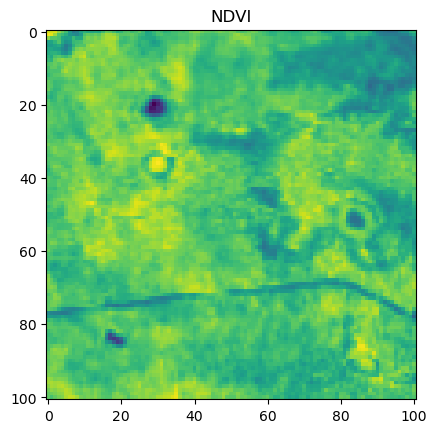

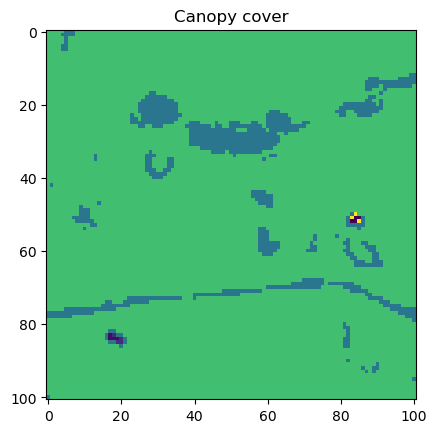

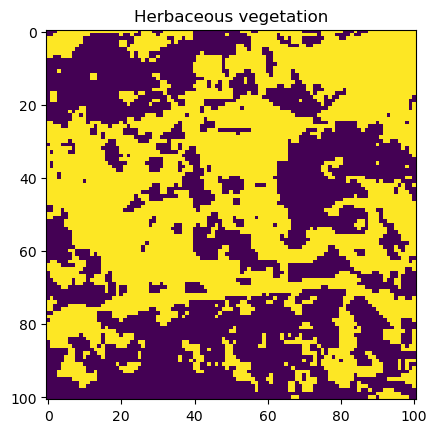

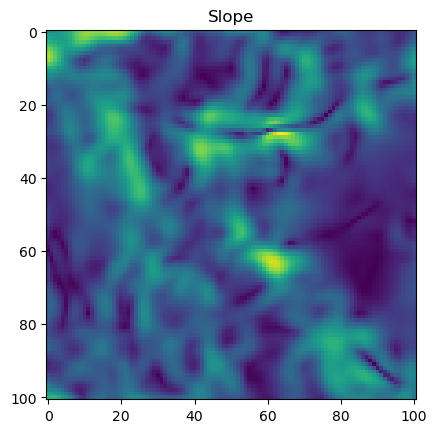

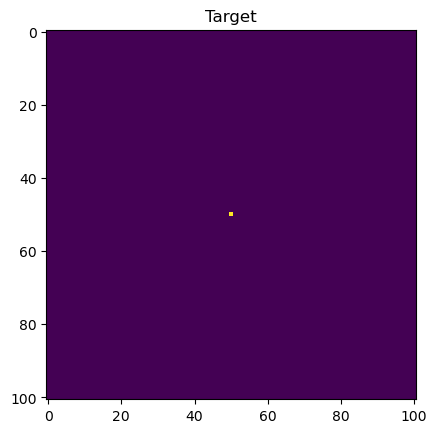

torch.Size([32, 101, 101, 2])


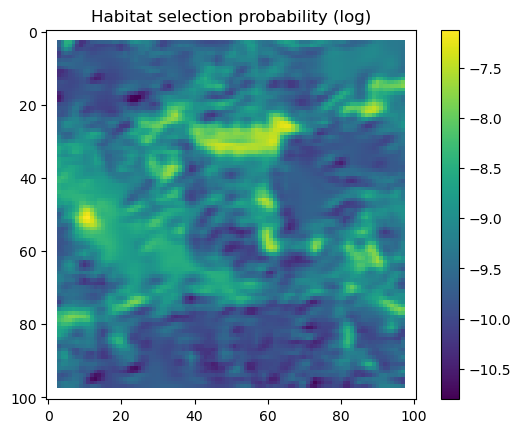

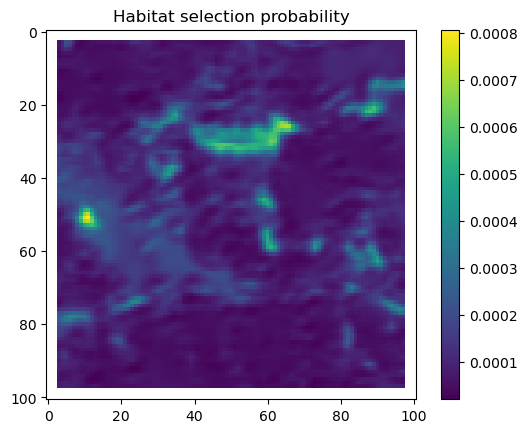

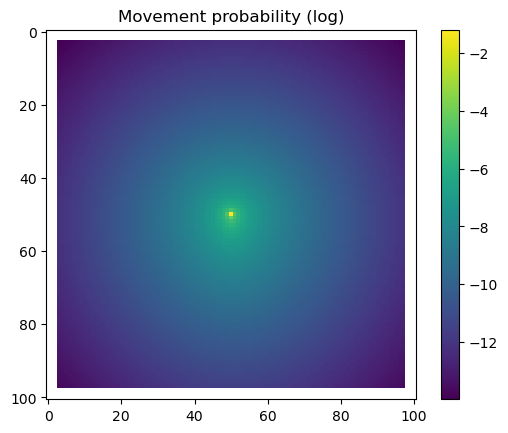

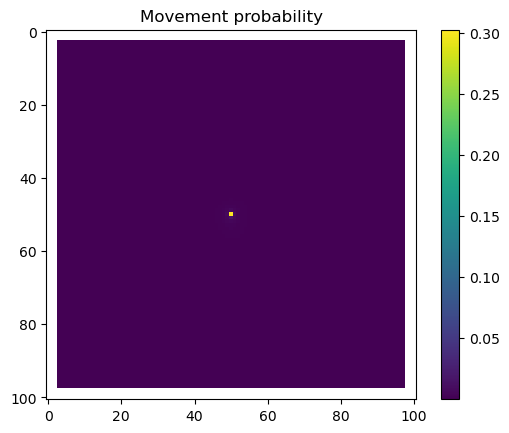

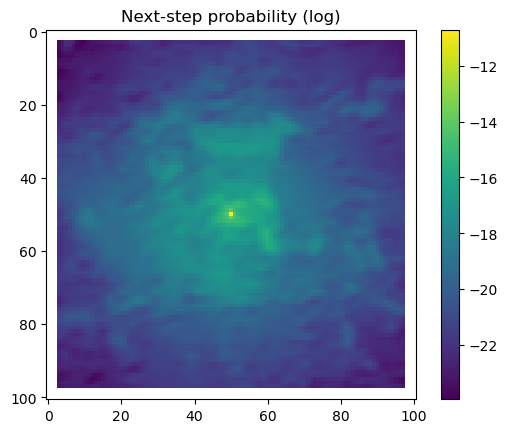

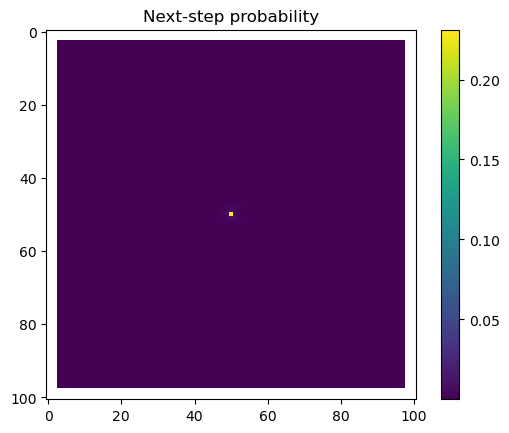

In [110]:
# 1. Set the model in evaluation mode
model.eval()

# Display image and label.
x1, x2, x3, labels = next(iter(dataloader_test))
print(f"Feature x1 batch shape: {x1.size()}")
print(f"Feature x2 batch shape: {x2.size()}")
print(f"Feature x3 batch shape: {x3.size()}")
print(f"Feature x4 batch shape: {x3.size()}")
print(f"Labels batch shape: {labels.size()}")

print(x2.detach().numpy()[0,:])

# Pull out the scalars
hour_t2_sin = x2.detach().numpy()[0,0]
hour_t2_cos = x2.detach().numpy()[0,1]
yday_t2_sin = x2.detach().numpy()[0,2]
yday_t2_cos = x2.detach().numpy()[0,3]
# bearing_sin = x2.detach().numpy()[0,4]
# bearing_cos = x2.detach().numpy()[0,5]
bearing = x3.detach().numpy()[0,0]

def recover_hour(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    hour = (12 * theta) / np.pi % 24
    return hour

hour_t2 = recover_hour(hour_t2_sin, hour_t2_cos)
print(hour_t2)

def recover_yday(sin_term, cos_term):
    # Calculate the angle theta
    theta = np.arctan2(sin_term, cos_term)
    # Calculate hour_t2
    yday = (365 * theta) / (2 * np.pi)  % 365
    return yday

yday_t2 = recover_yday(yday_t2_sin, yday_t2_cos)
print(yday_t2)

# def recover_bearing(bearing_sin, bearing_cos):
#     # Calculate the angle (bearing) in radians
#     bearing = np.arctan2(bearing_sin, bearing_cos)
#     # Convert bearing from radians to degrees
#     bearing_degrees = np.degrees(bearing) % 360
#     return bearing_degrees

# bearing = recover_bearing(bearing_sin, bearing_cos)
print(bearing)

# print(loss_fn(model((x1, x2, x3)), labels))

# Create output directory for each sample
hour_t2_integer = int(hour_t2)
yday_t2_integer = int(yday_t2)

output_dir = f'outputs/conv_filters/id{buffalo_id}_yday{yday_t2_integer}_hour{hour_t2_integer}.png'
os.makedirs(output_dir, exist_ok=True)

# plot the covariates
plt.imshow(x1.detach().cpu().numpy()[0,0,:,:])
# plt.colorbar()
plt.title('NDVI')
plt.savefig(f'{output_dir}/ndvi_id2005_{today_date}.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

plt.imshow(x1.detach().cpu().numpy()[0,1,:,:])
# plt.colorbar()
plt.title('Canopy cover')
plt.savefig(f'{output_dir}/canopy_id2005_{today_date}.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

plt.imshow(x1.detach().cpu().numpy()[0,2,:,:])
# plt.colorbar()
plt.title('Herbaceous vegetation')
plt.savefig(f'{output_dir}/herby_id2005_{today_date}.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

plt.imshow(x1.detach().cpu().numpy()[0,3,:,:])
# plt.colorbar()
plt.title('Slope')
plt.savefig(f'{output_dir}/slope_id2005_{today_date}.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# plot the target
plt.imshow(labels.detach().cpu().numpy()[0,:,:])
# plt.colorbar()
plt.title('Target')
plt.savefig(f'{output_dir}/target_id2005_{today_date}.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

#Test that the model runs
# x1, x2 = synth_ds[0][0], synth_ds[0][1]

# Move input tensors to the GPU if available
x1 = x1.to(device)
x2 = x2.to(device)
x3 = x3.to(device)

test = model((x1, x2, x3))
print(test.shape)
# print(test)

# plot the results of the habitat density as an image
hab_density = test.detach().cpu().numpy()[0,:,:,0]
hab_density_exp = np.exp(hab_density)
# print(np.sum(hab_density_exp))

# Create the mask for x and y coordinates
x_mask = np.ones_like(hab_density)
y_mask = np.ones_like(hab_density)

# mask out cells on the edges that affect the colour scale
x_mask[:, :3] = -np.inf
x_mask[:, 98:] = -np.inf
y_mask[:3, :] = -np.inf
y_mask[98:, :] = -np.inf

hab_density_mask = hab_density * x_mask * y_mask
hab_density_exp_mask = hab_density_exp * x_mask * y_mask

# plot the results of the habitat density as an image - in log scale
plt.imshow(hab_density_mask)
plt.colorbar()
plt.title('Habitat selection probability (log)')
plt.savefig(f'{output_dir}/hab_log_prob_id2005_{today_date}.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# plot the results of the habitat density as an image - as probabilities
plt.imshow(hab_density_exp_mask)
plt.colorbar()
plt.title('Habitat selection probability')
plt.savefig(f'{output_dir}/hab_prob_id2005_{today_date}.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# movement probability
move_density = test.detach().cpu().numpy()[0,:,:,1]
move_density_exp = np.exp(move_density)
# print(np.sum(move_density_exp))

move_density_mask = move_density * x_mask * y_mask
move_density_exp_mask = move_density_exp * x_mask * y_mask

# plot the results of the movement density as an image - in log scale
plt.imshow(move_density_mask)
plt.colorbar()
plt.title('Movement probability (log)')
plt.savefig(f'{output_dir}/move_log_prob_id2005_{today_date}.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# plot the results of the movement density as an image - as probabilities
plt.imshow(move_density_exp_mask)
plt.colorbar()
plt.title('Movement probability')
plt.savefig(f'{output_dir}/move_prob_id2005_{today_date}.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# next step probability
step_density = test[0, :, :, 0] + test[0, :, :, 1]
step_density = step_density.detach().cpu().numpy()
step_density_exp = np.exp(step_density)
# print('Sum of step density exp = ', np.sum(step_density_exp))

step_density_exp_norm = step_density_exp / np.sum(step_density_exp)
# print('Sum of step density exp norm = ', np.sum(step_density_exp_norm))

step_density_mask = step_density * x_mask * y_mask
step_density_exp_norm_mask = step_density_exp_norm * x_mask * y_mask

# results of the habitat and movement densities
# log-scale
plt.imshow(step_density_mask)
plt.colorbar()
plt.title('Next-step probability (log)')
plt.savefig(f'{output_dir}/step_log_prob_id2005_{today_date}.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# exponentiated
plt.imshow(step_density_exp_norm_mask)
plt.colorbar()
plt.title('Next-step probability')
plt.savefig(f'{output_dir}/step_prob_id2005_{today_date}.png', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

### Extracting convolution layer outputs

Sequential(
  (0): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
Filters shape: torch.Size([4, 8, 3, 3])


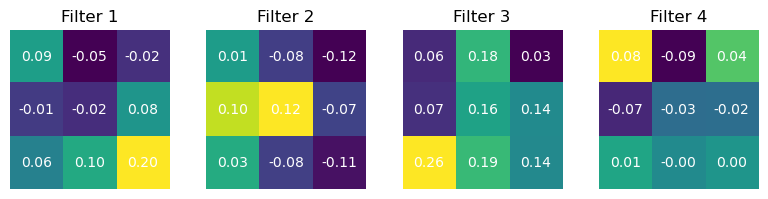

Filters shape: torch.Size([4, 4, 3, 3])


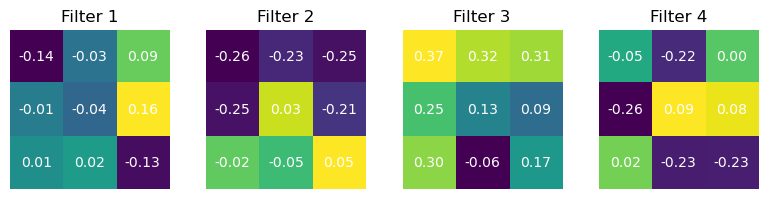

Filters shape: torch.Size([1, 4, 3, 3])


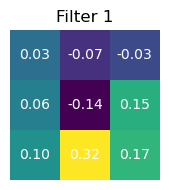

In [56]:
# Extract the weight tensor
# (If your first convolution layer is named differently, adjust accordingly)
# filters = model.conv1.weight.data.clone().cpu()
print(model.conv_habitat.conv2d)

# Suppose your model is already trained
# model = ConvJointModel(params)
# model.load_state_dict(torch.load("my_model_state.pth"))
model.eval()

# Extract first conv layer in conv_habitat
filters_c1 = model.conv_habitat.conv2d[0].weight.data.clone().cpu()
print("Filters shape:", filters_c1.shape)  
# Typically (out_channels, in_channels, kernel_H, kernel_W)

# Plot these filters (just the first channel of each filter for brevity)
num_filters_c1 = filters_c1.shape[0]
fig, axes = plt.subplots(1, num_filters_c1, figsize=(2*num_filters_c1, 2))
for i in range(num_filters_c1):
    kernel = filters_c1[i, 0, :, :]  # first input channel
    im = axes[i].imshow(kernel, cmap='viridis')
    axes[i].axis('off')
    axes[i].set_title(f'Filter {i+1}')
    # Annotate each cell with the numeric value
    for (j, k), val in np.ndenumerate(kernel):
        axes[i].text(k, j, f'{val:.2f}', ha='center', va='center', color='white')
plt.tight_layout()
plt.savefig(f'outputs/id2005_conv1_filters_{today_date}.png', dpi=600, bbox_inches='tight')
plt.show()

# Extract second conv layer in conv_habitat
filters_c2 = model.conv_habitat.conv2d[2].weight.data.clone().cpu()
print("Filters shape:", filters_c2.shape)
# Typically (out_channels, in_channels, kernel_H, kernel_W)

# Plot these filters (just the first channel of each filter for brevity)
num_filters_c2 = filters_c2.shape[0]
fig, axes = plt.subplots(1, num_filters_c2, figsize=(2*num_filters_c2, 2))
for i in range(num_filters_c2):
    kernel = filters_c2[i, 0, :, :]  # first input channel
    axes[i].imshow(kernel, cmap='viridis')
    axes[i].axis('off')
    axes[i].set_title(f'Filter {i+1}')
    # Annotate each cell with the numeric value
    for (j, k), val in np.ndenumerate(kernel):
        axes[i].text(k, j, f'{val:.2f}', ha='center', va='center', color='white')
plt.tight_layout()
plt.savefig(f'outputs/id2005_conv2_filters_{today_date}.png', dpi=600, bbox_inches='tight')
plt.show()

# Extract final conv layer in conv_habitat
filters_c3 = model.conv_habitat.conv2d[4].weight.data.clone().cpu()
print("Filters shape:", filters_c3.shape)

# Plot these filters (just the first channel of each filter for brevity)
fig, ax = plt.subplots(figsize=(2, 2))
kernel = filters_c3[0, 0, :, :]  # first filter, first input channel
im = ax.imshow(kernel, cmap='viridis')
ax.axis('off')
ax.set_title('Filter 1')
# Annotate each cell with the numeric value
for (j, k), val in np.ndenumerate(kernel):
    ax.text(k, j, f'{val:.2f}', ha='center', va='center', color='white')
plt.tight_layout()
plt.savefig(f'outputs/id2005_conv3_filters_{today_date}.png', dpi=600, bbox_inches='tight')
plt.show()

### Save each filter channel individually

In [65]:
# Assuming 'filters_c1' is a tensor of shape (num_filters, num_channels, height, width)
# Replace 'filters_c1' with your actual filters tensor
filters_c1 = model.conv_habitat.conv2d[0].weight.data.cpu().numpy()

num_filters = filters_c1.shape[0]
num_channels = filters_c1.shape[1]

for i in range(num_filters):
    for j in range(num_channels):
        kernel = filters_c1[i, j, :, :]  # filter for channel j
        fig, ax = plt.subplots(figsize=(2, 2))
        im = ax.imshow(kernel, cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Filter {i+1}, Channel {j+1}')
        # Annotate each cell with the numeric value
        for (k, l), val in np.ndenumerate(kernel):
            ax.text(l, k, f'{val:.2f}', ha='center', va='center', color='white')
        plt.tight_layout()
        plt.savefig(f'outputs/conv_filters/conv_layer_1_filter_{i+1}_channel_{j+1}.png', dpi=600, bbox_inches='tight')
        # plt.show()
        plt.close(fig)

In [ ]:
# Assuming 'filters_c1' is a tensor of shape (num_filters, num_channels, height, width)
# Replace 'filters_c1' with your actual filters tensor
filters_c1 = model.conv_habitat.conv2d[2].weight.data.cpu().numpy()

num_filters = filters_c1.shape[0]
num_channels = filters_c1.shape[1]

for i in range(num_filters):
    for j in range(num_channels):
        kernel = filters_c1[i, j, :, :]  # filter for channel j
        fig, ax = plt.subplots(figsize=(2, 2))
        im = ax.imshow(kernel, cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Filter {i+1}, Channel {j+1}')
        # Annotate each cell with the numeric value
        for (k, l), val in np.ndenumerate(kernel):
            ax.text(l, k, f'{val:.2f}', ha='center', va='center', color='white')
        plt.tight_layout()
        plt.savefig(f'outputs/conv_filters/conv_layer_2_filter_{i+1}_channel_{j+1}.png', dpi=600, bbox_inches='tight')
        # plt.show()
        plt.close(fig)

In [ ]:
# Assuming 'filters_c1' is a tensor of shape (num_filters, num_channels, height, width)
# Replace 'filters_c1' with your actual filters tensor
filters_c1 = model.conv_habitat.conv2d[4].weight.data.cpu().numpy()

num_filters = filters_c1.shape[0]
num_channels = filters_c1.shape[1]

for i in range(num_filters):
    for j in range(num_channels):
        kernel = filters_c1[i, j, :, :]  # filter for channel j
        fig, ax = plt.subplots(figsize=(2, 2))
        im = ax.imshow(kernel, cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Filter {i+1}, Channel {j+1}')
        # Annotate each cell with the numeric value
        for (k, l), val in np.ndenumerate(kernel):
            ax.text(l, k, f'{val:.2f}', ha='center', va='center', color='white')
        plt.tight_layout()
        plt.savefig(f'outputs/conv_filters/conv_layer_3_filter_{i+1}_channel_{j+1}.png', dpi=600, bbox_inches='tight')
        # plt.show()
        plt.close(fig)

### Activation map hooks

### Conv layer 1

Feature map shape: torch.Size([32, 4, 101, 101])


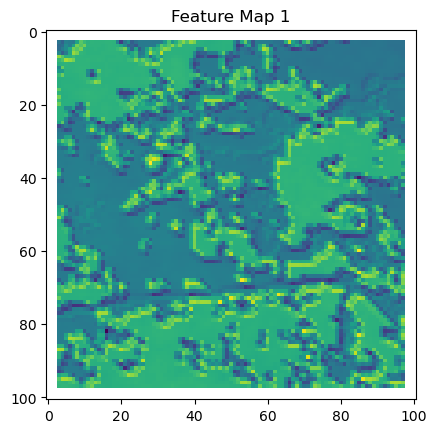

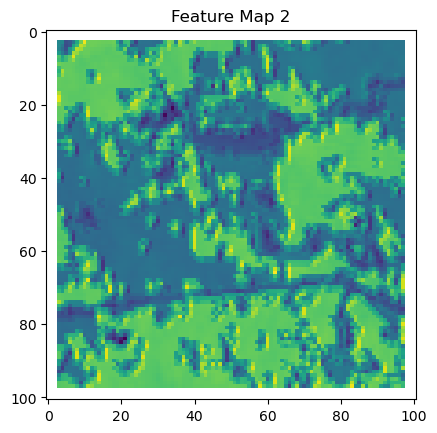

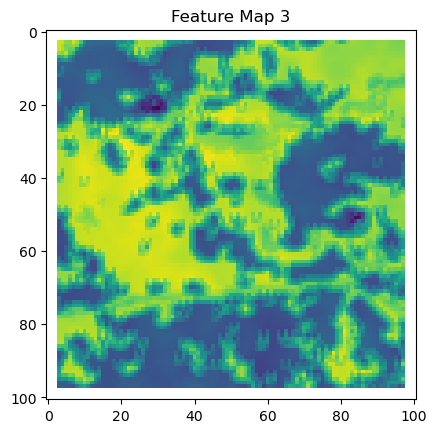

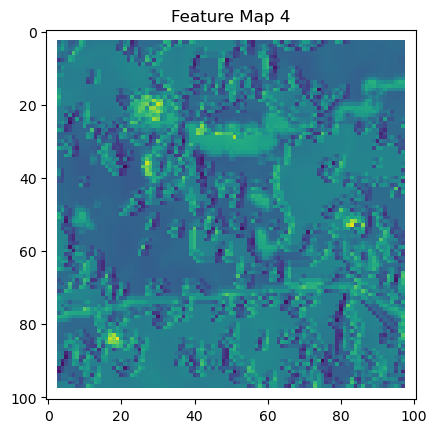

In [111]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        # Store in a dictionary
        activation[name] = output.detach()
    return hook

# Assuming 'model' is already defined and has the layer 'conv_habitat.conv2d[0]'
model.conv_habitat.conv2d[0].register_forward_hook(get_activation("hab_conv0"))

# Now run a forward pass
# x is a tuple of inputs in your model: (spatial_data_x, scalars_to_grid, bearing_x), etc.
# out = model(x)
out = model((x1, x2, x3))

# After the forward pass, the feature maps are in activation["hab_conv1"]
feat_maps = activation["hab_conv0"].cpu()
print("Feature map shape:", feat_maps.shape)
# Typically (batch_size, out_channels, height, width)

# Plot the feature maps for the first sample in the batch
feat_maps_sample = feat_maps[0]  # shape: (out_channels, H, W)
num_maps = feat_maps_sample.shape[0]
cols = 8
rows = (num_maps + cols - 1) // cols

# fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
# axes = axes.flatten()

for i in range(num_maps):
    plt.figure()
    plt.imshow(feat_maps_sample[i].numpy() * x_mask * y_mask, cmap='viridis')
    # plt.axis('off')
    plt.title(f"Feature Map {i+1}")
    plt.savefig(f'{output_dir}/conv_habitat_layer_1_feature_map_{i}_{today_date}.png', dpi=600, bbox_inches='tight')
    plt.show()


### Conv layer 2

Feature map shape: torch.Size([32, 4, 101, 101])


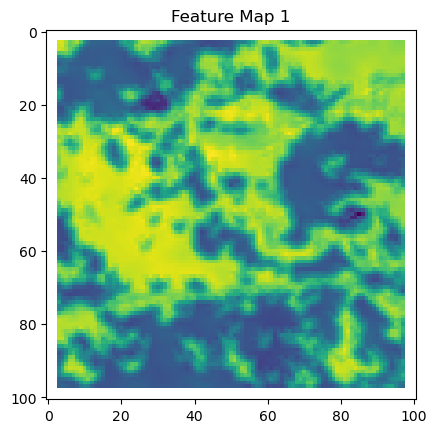

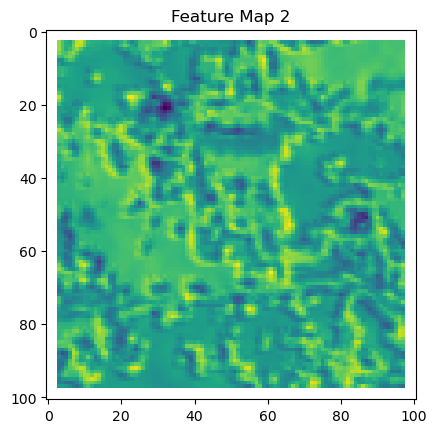

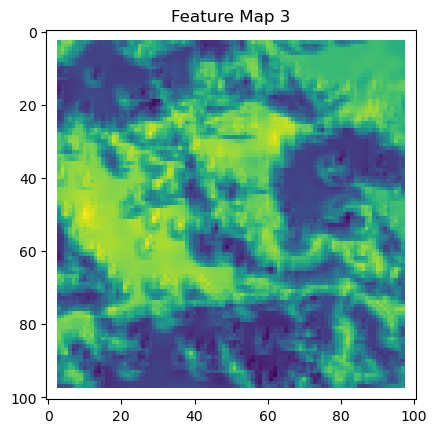

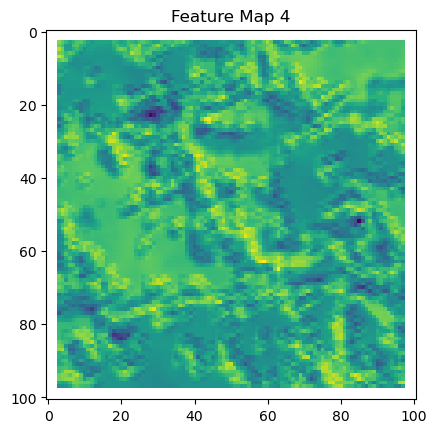

In [112]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        # Store in a dictionary
        activation[name] = output.detach()
    return hook

# Assuming 'model' is already defined and has the layer 'conv_habitat.conv2d[0]'
model.conv_habitat.conv2d[2].register_forward_hook(get_activation("hab_conv2"))

# Now run a forward pass
# x is a tuple of inputs in your model: (spatial_data_x, scalars_to_grid, bearing_x), etc.
# out = model(x)
out = model((x1, x2, x3))

# After the forward pass, the feature maps are in activation["hab_conv1"]
feat_maps = activation["hab_conv2"].cpu()
print("Feature map shape:", feat_maps.shape)
# Typically (batch_size, out_channels, height, width)

# Plot the feature maps for the first sample in the batch
feat_maps_sample = feat_maps[0]  # shape: (out_channels, H, W)
num_maps = feat_maps_sample.shape[0]
cols = 8
rows = (num_maps + cols - 1) // cols

# fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
# axes = axes.flatten()

for i in range(num_maps):
    plt.figure()
    plt.imshow(feat_maps_sample[i].numpy() * x_mask * y_mask, cmap='viridis')
    # plt.axis('off')
    plt.title(f"Feature Map {i+1}")
    plt.savefig(f'{output_dir}/conv_habitat_layer_2_feature_map_{i}_{today_date}.png', dpi=600, bbox_inches='tight')
    plt.show()


### Conv layer 3

Feature map shape: torch.Size([32, 1, 101, 101])


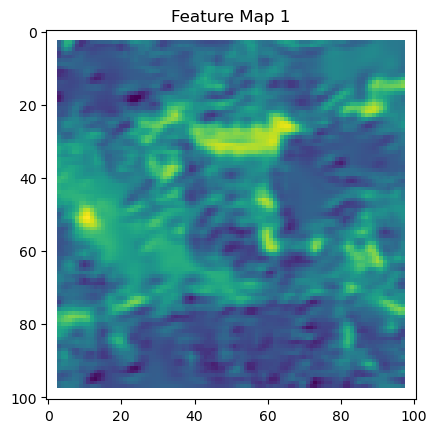

In [113]:
activation = {}

def get_activation(name):
    def hook(model, input, output):
        # Store in a dictionary
        activation[name] = output.detach()
    return hook

# Assuming 'model' is already defined and has the layer 'conv_habitat.conv2d[0]'
model.conv_habitat.conv2d[4].register_forward_hook(get_activation("hab_conv3"))

# Now run a forward pass
# x is a tuple of inputs in your model: (spatial_data_x, scalars_to_grid, bearing_x), etc.
# out = model(x)
out = model((x1, x2, x3))

# After the forward pass, the feature maps are in activation["hab_conv1"]
feat_maps = activation["hab_conv3"].cpu()
print("Feature map shape:", feat_maps.shape)
# Typically (batch_size, out_channels, height, width)

# Plot the feature maps for the first sample in the batch
feat_maps_sample = feat_maps[0]  # shape: (out_channels, H, W)
num_maps = feat_maps_sample.shape[0]
cols = 8
rows = (num_maps + cols - 1) // cols

# fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
# axes = axes.flatten()

for i in range(num_maps):
    plt.figure()
    plt.imshow(feat_maps_sample[i].numpy() * x_mask * y_mask, cmap='viridis')
    # plt.axis('off')
    plt.title(f"Feature Map {i+1}")
    plt.savefig(f'{output_dir}/conv_habitat_layer_3_feature_map_{i}_{today_date}.png', dpi=600, bbox_inches='tight')
    plt.show()


### Adding hooks to check movement parameters

In [ ]:
# Register hook to capture the output of FCN_block_all_movement
intermediate_output = []

def hook(module, input, output):
    intermediate_output.append(output)

hook_handle = model.fcn_movement_all.register_forward_hook(hook)

# Get the output from the full model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    final_output = model((x1, x2, x3))

# Print the intermediate output
print("Intermediate output shape:", intermediate_output[0].shape)
print("Intermediate output values:", intermediate_output[0][0])

# Remove hook
hook_handle.remove()

# gamma_shape1, gamma_scale1, gamma_weight1, gamma_shape2, gamma_scale2, gamma_weight2, vonmises_kappa1, vonmises_weight1, vonmises_kappa2, vonmises_weight2 = intermediate_output[0][0]
gamma_shape1, gamma_scale1, gamma_weight1, gamma_shape2, gamma_scale2, gamma_weight2, vonmises_mu1, vonmises_kappa1, vonmises_weight1, vonmises_mu2, vonmises_kappa2, vonmises_weight2 = intermediate_output[0][0]
# gamma_shape1, gamma_scale1, vonmises_mu1, vonmises_kappa1 = intermediate_output[0][0]


# Gamma 1 parameters
print("Gamma shape 1:", torch.exp(gamma_shape1))
print("Gamma scale 1:", torch.exp(gamma_scale1))
print("Gamma weight 1:", torch.exp(gamma_weight1)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2)))

# Gamma 2 parameters
print("Gamma shape 2:", torch.exp(gamma_shape2))
print("Gamma scale 2:", torch.exp(gamma_scale2)*500)
print("Gamma weight 2:", torch.exp(gamma_weight2)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2)))

# Von Mises 1 parameters
# print("Von Mises mu 1:", vonmises_mu1 % (2*np.pi))
print("Von Mises kappa 1:", torch.exp(vonmises_kappa1))
print("Von Mises weight 1:", torch.exp(vonmises_weight1)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2)))

# Von Mises 2 parameters
# print("Von Mises mu 2:", vonmises_mu2 % (2*np.pi))
print("Von Mises kappa 2:", torch.exp(vonmises_kappa2))
print("Von Mises weight 2:", torch.exp(vonmises_weight2)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2)))


Plot the distributions

In [ ]:
# Gamma densities for the mixture distribution
def gamma_density(x, shape, scale):
    return -1*torch.lgamma(shape) -shape*torch.log(scale) + (shape - 1)*torch.log(x) - x/scale

# von Mises densities for the mixture distribution
def vonmises_density(x, kappa, vm_mu):
    return kappa*torch.cos(x - vm_mu) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa)))


### Round the weight variables

# Gamma weights
gamma_weight1_recovered = torch.exp(gamma_weight1)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))
rounded_gamma_weight1 = round(gamma_weight1_recovered.item(), 2)
gamma_weight2_recovered = torch.exp(gamma_weight2)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))
rounded_gamma_weight2 = round(gamma_weight2_recovered.item(), 2)

# von Mises weights
vonmises_weight1_recovered = torch.exp(vonmises_weight1)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))
rounded_vm_weight1 = round(vonmises_weight1_recovered.item(), 2)
vonmises_weight2_recovered = torch.exp(vonmises_weight2)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))
rounded_vm_weight2 = round(vonmises_weight2_recovered.item(), 2)


# parameters of the Gamma mixture distributions
# Generate x values from 1 to 1000
x_values = torch.linspace(1, 101, 1000).to(device)
gamma1_density = gamma_density(x_values, torch.exp(gamma_shape1), torch.exp(gamma_scale1))
gamma2_density = gamma_density(x_values, torch.exp(gamma_shape2), torch.exp(gamma_scale2)*500)
gamma_mixture_density = gamma_weight1_recovered*torch.exp(gamma1_density) + gamma_weight2_recovered*torch.exp(gamma2_density)

# Move tensors to CPU and convert to NumPy arrays
x_values_np = x_values.cpu().numpy()
gamma1_density_np = np.exp(gamma1_density.cpu().numpy())  # Move to CPU before np.exp
gamma2_density_np = np.exp(gamma2_density.cpu().numpy())  # Move to CPU before np.exp
gamma_mixture_density_np = gamma_mixture_density.cpu().numpy()

# Plot the gamma density function
plt.plot(x_values_np, gamma1_density_np, label='Gamma 1 Density')
plt.plot(x_values_np, gamma1_density_np, label=f'Gamma 1 Density: weight = {rounded_gamma_weight1}')
plt.plot(x_values_np, gamma2_density_np, label=f'Gamma 2 Density: weight = {rounded_gamma_weight2}')
plt.plot(x_values_np, gamma_mixture_density_np, label='Gamma Mixture Density')
# plt.xscale('log')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Gamma Density Function')
plt.legend()
plt.show()

# parameters of the von mises mixture distribution
# Generate x values from -pi to pi
x_values = torch.linspace(-np.pi, np.pi, 1000).to(device)
vonmises1_density = vonmises_density(x_values, torch.exp(vonmises_kappa1), vonmises_mu1)
vonmises2_density = vonmises_density(x_values, torch.exp(vonmises_kappa2), vonmises_mu2)
# vonmises1_density = vonmises_density(x_values, torch.exp(vonmises_kappa1), 0)
# vonmises2_density = vonmises_density(x_values, torch.exp(vonmises_kappa2), -torch.pi)
vonmises_mixture_density = vonmises_weight1_recovered*torch.exp(vonmises1_density) + vonmises_weight2_recovered*torch.exp(vonmises2_density)

# Move tensors to CPU and convert to NumPy arrays
x_values_np = x_values.cpu().numpy() # Move x_values to cpu
vonmises1_density_np = np.exp(vonmises1_density.cpu().numpy())  # Move to CPU before np.exp
vonmises2_density_np = np.exp(vonmises2_density.cpu().numpy())  # Move to CPU before np.exp
vonmises_mixture_density_np = vonmises_mixture_density.cpu().numpy() # Move vonmises_mixture_density to cpu

# Plot the von mises density function
plt.plot(x_values_np, vonmises1_density_np, label='Von Mises 1 Density')
plt.plot(x_values_np, vonmises1_density_np, label=f'Von Mises 1 Density: weight = {rounded_vm_weight1}')
plt.plot(x_values_np, vonmises2_density_np, label=f'Von Mises 2 Density: weight = {rounded_vm_weight2}')
plt.plot(x_values_np, vonmises_mixture_density_np, label='Von Mises Mixture Density')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Von Mises Density Function')
plt.ylim(0, 1.2)  # Set the y-axis limits
plt.legend()
plt.show()

In [ ]:
# Register hook to capture the output of FCN_block_all_movement
intermediate_output = []

def hook(module, input, output):
    intermediate_output.append(output)

hook_handle = model.fcn_movement_all.register_forward_hook(hook)

# Get the output from the full model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation
    final_output = model((x1, x2, x3))

# Extract parameters for each batch
gamma_shape1_list = []
gamma_scale1_list = []
gamma_weight1_list = []
gamma_shape2_list = []
gamma_scale2_list = []
gamma_weight2_list = []
vonmises_mu1_list = []
vonmises_kappa1_list = []
vonmises_weight1_list = []
vonmises_mu2_list = []
vonmises_kappa2_list = []
vonmises_weight2_list = []

for batch_output in intermediate_output:
    for sample_output in batch_output:
      # gamma_shape1, gamma_scale1, vonmises_mu1, vonmises_kappa1 = sample_output
      # gamma_shape1, gamma_scale1, gamma_weight1, gamma_shape2, gamma_scale2, gamma_weight2, vonmises_kappa1, vonmises_weight1, vonmises_kappa2, vonmises_weight2 = sample_output
      gamma_shape1, gamma_scale1, gamma_weight1, gamma_shape2, gamma_scale2, gamma_weight2, vonmises_mu1, vonmises_kappa1, vonmises_weight1, vonmises_mu2, vonmises_kappa2, vonmises_weight2 = sample_output

      gamma_shape1_list.append(torch.exp(gamma_shape1).item())
      gamma_scale1_list.append(torch.exp(gamma_scale1).item())
      gamma_weight1_list.append((torch.exp(gamma_weight1)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))).item())
      gamma_shape2_list.append(torch.exp(gamma_shape2).item())
      gamma_scale2_list.append((torch.exp(gamma_scale2)*500).item())
      gamma_weight2_list.append((torch.exp(gamma_weight2)/(torch.exp(gamma_weight1) + torch.exp(gamma_weight2))).item())
      vonmises_mu1_list.append((vonmises_mu1 % (2*np.pi)).item())
      vonmises_kappa1_list.append(torch.exp(vonmises_kappa1).item())
      vonmises_weight1_list.append((torch.exp(vonmises_weight1)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))).item())
      vonmises_mu2_list.append((vonmises_mu2 % (2*np.pi)).item())
      vonmises_kappa2_list.append(torch.exp(vonmises_kappa2).item())
      vonmises_weight2_list.append((torch.exp(vonmises_weight2)/(torch.exp(vonmises_weight1) + torch.exp(vonmises_weight2))).item())

# Plot parameters
def plot_histogram(data, title, xlabel):
    plt.figure()
    plt.hist(data, bins=30, alpha=0.75)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.show()

plot_histogram(gamma_shape1_list, 'Gamma Shape 1 Distribution', 'Shape 1')
plot_histogram(gamma_scale1_list, 'Gamma Scale 1 Distribution', 'Scale 1')
plot_histogram(gamma_weight1_list, 'Gamma Weight 1 Distribution', 'Weight 1')
plot_histogram(gamma_shape2_list, 'Gamma Shape 2 Distribution', 'Shape 2')
plot_histogram(gamma_scale2_list, 'Gamma Scale 2 Distribution', 'Scale 2')
plot_histogram(gamma_weight2_list, 'Gamma Weight 2 Distribution', 'Weight 2')
plot_histogram(vonmises_mu1_list, 'Von Mises Mu 1 Distribution', 'Mu 1')
plot_histogram(vonmises_kappa1_list, 'Von Mises Kappa 1 Distribution', 'Kappa 1')
plot_histogram(vonmises_weight1_list, 'Von Mises Weight 1 Distribution', 'Weight 1')
plot_histogram(vonmises_mu2_list, 'Von Mises Mu 2 Distribution', 'Mu 2')
plot_histogram(vonmises_kappa2_list, 'Von Mises Kappa 2 Distribution', 'Kappa 2')
plot_histogram(vonmises_weight2_list, 'Von Mises Weight 2 Distribution', 'Weight 2')

# Remove hook
hook_handle.remove()

In [ ]:
test_bearing = torch.tensor([[1.0]], device=device)

test_block = Params_to_Grid_Block(params)
# movement_density = test_block(torch.rand(1, 4, device=device))
# provide a tensor of shape (batch_size, 4) where the 4 columns are the parameters of the gamma and von mises distributions
# providing values in log space as the values are exponentiated in the forward pass
# movement_density = test_block(torch.tensor([[np.log(0.5), np.log(200), np.log(0.25), # gamma 1 - shape, scale and weight
#                                              np.log(2.5), np.log(300), np.log(0.75), # gamma 2 - shape, scale and weight
#                                              5, np.log(1), np.log(0.75),
#                                              -10, np.log(1.5), np.log(0.25)]], device=device), test_bearing)

movement_density = test_block(intermediate_output[0][0].unsqueeze(dim = 0), test_bearing)
# providing values as the model sees them
# movement_density = test_block(torch.tensor([[-.5, -.5, -.5, -.5]], device=device))
print(movement_density)
print(movement_density.shape)

# plot the results of the movement density as an image
plt.imshow(movement_density.detach().cpu()[0])
plt.colorbar()
plt.show()

### Visualise CNN layers

In [ ]:
# Visualize the intermediate activations
# for layer_name, activation in activations.items():
#     print(f'Layer: {layer_name}, Shape: {activation.shape}')
#     plt.imshow(activation[0, 0].cpu().numpy(), cmap='gray')
#     plt.title(layer_name)
#     plt.show()